<a href="https://colab.research.google.com/github/mfdali/br-oil-production/blob/main/mvp_dataengineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Data Engineering

@author: Monique Dali

course: Data Science & Analytics

university: PUC-Rio

## Database

The information was extracted from the public database of Brazilian's national oil regulator agency. This dataset contains montly information about crude oil and natural gas production per well located in Brazil. Only the accessible montly production of 2023 was downloaded. On the time of this work, July was the last month updated.

The dataset is available in: https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/producao-de-petroleo-e-gas-natural-por-poco


Metadata is also available in: https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/arquivos-producao-de-petroleo-e-gas-natural-por-poco/metadados-dados-producao-poco.pdf

AWS was chosen as the cloud service to perform the ETL jobs.

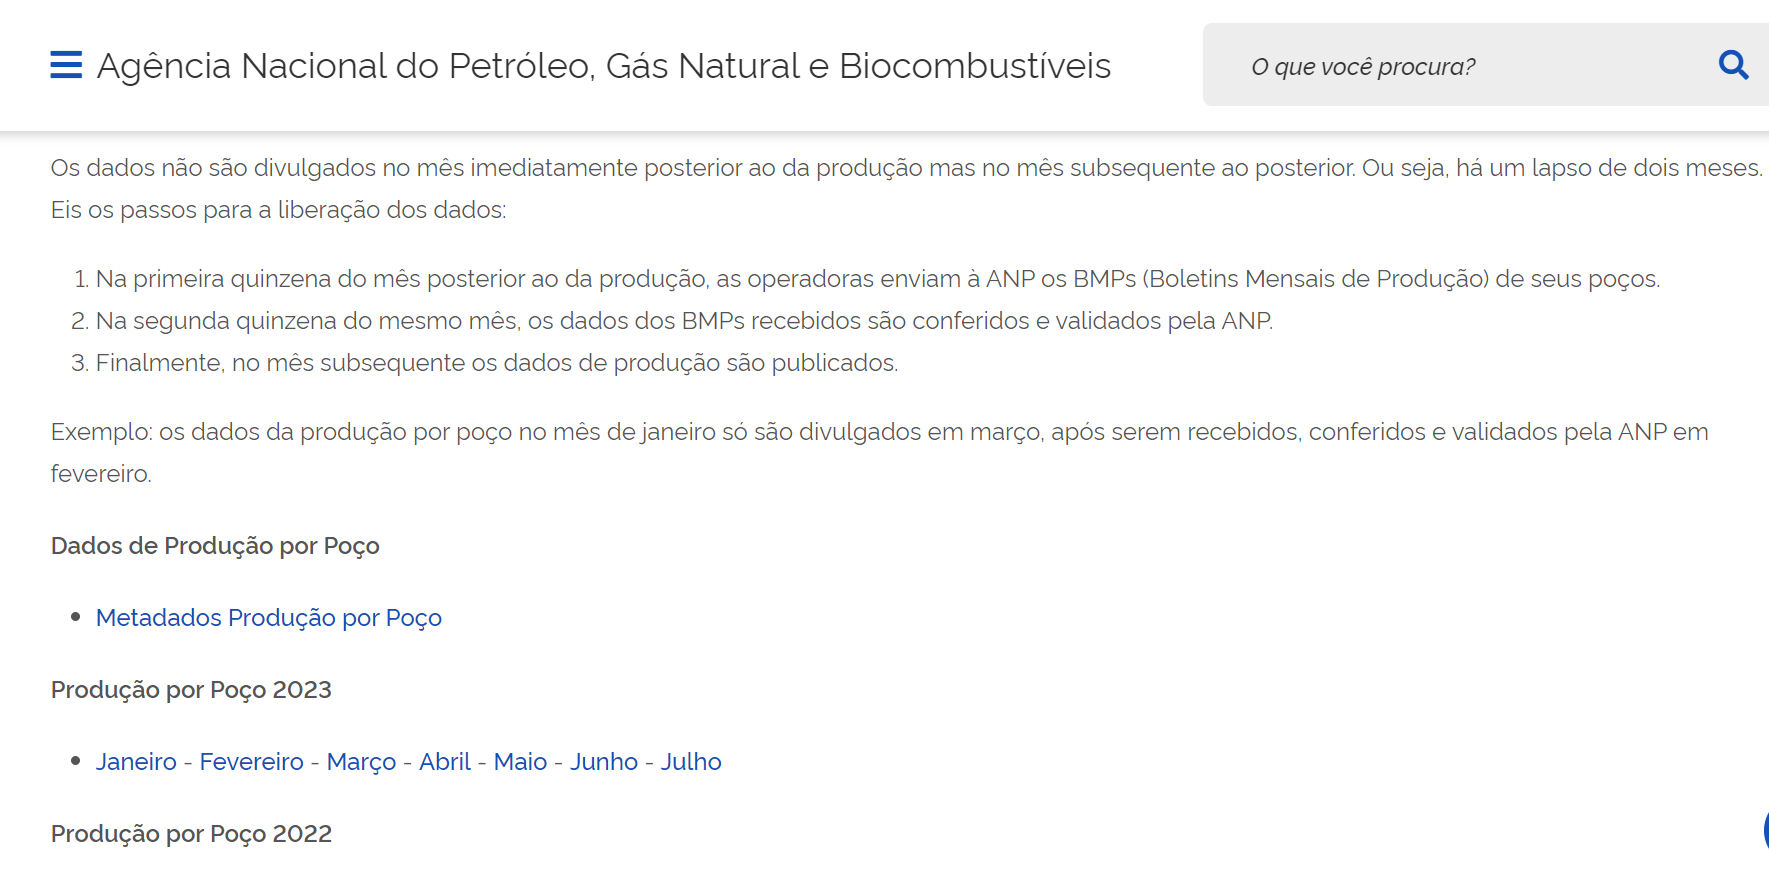

## **Proposal**

With this database, data analysis process wants to answer a couple of general questions about crude oil commercial extraction during 2023 in Brazil.

**Goals**
1. What is the crude oil production of brazil accumulated in 2023?
2. What is the crude oil production accumulated per well location?
3. What is the most productive state?
4. What is the most productive field?
5. What is the most productive well?

Water is an undesirable subproduct of oil extraction. Water injection is widely used as secondary recovery method in wells. However, it is not good to produce water in high levels. Mature wells have oil production curve in decline.

6. What is the worst state in terms of crude oil extraction efficience?
7. What are the 10 most inneficient wells?


## Data Transformation

First, it is necessary to group datasets by month that originally were divided per well location: onshore, offshore and presalt. For this, the following script in Python was developed. Pandas library have been used to read, aggregate rows and export a new file. Then, one file per month can be uploaded to S3.

Some transformations were performed:

1 - delimiter changed from semicolon(;) to comma(,)

2 - decimal separator from comma(,) to dot(.)

3 - new column with the well location extracted from the filename of original data before join

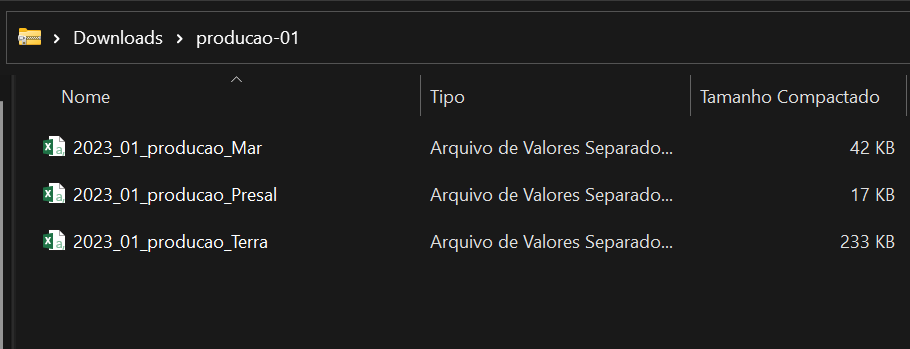

1. Import libraries to run notebook

In [65]:
# Import libraries
import pandas as pd
import os
import gdown
import zipfile
import time
import requests
from google.colab import files

2. Tools: classes & functions

In [64]:
# Class to Load and transform data
class LoadData:

    def _load_file(self, url,header_list,skiprows,delimiter,decimal,thousands):
        ''' Load dataset '''
        return pd.read_csv(url, delimiter=delimiter,header=None,names=header_list,skiprows=skiprows,encoding='ISO-8859-1',decimal=decimal,thousands=thousands)

    def _create_folder(self, path):
        '''Create folder to store data'''

        # Check whether the specified path exists or not
        #path = "./dataset/"
        isExist = os.path.exists(path)
        if not isExist:
          # Create a new directory if it does not exist
          os.makedirs(path)
        return path

    def aggregate_rows(self, year, months, folder: str, path, header_list,well_location_type_pt,well_location_type_en):
      '''Join 3 datasets to create a month data for each month available'''
      # Create folder to store data in Google Colab
      path = self._create_folder(path)

      # Loop to create a file for each month
      for month in range(1,months+1):
        # Create table to receive header and montly data
        oil2023_dataset = pd.DataFrame(columns=header_list)
        output_filename = path + str(year) + "_" + format(month,'02d') + "_wellproduction.txt"

        # Loop to join data for each month
        for i in range(len(well_location_type_pt)):
          url = folder + str(year) + '_' + format(month,'02d') +'_producao_' + well_location_type_pt[i] + '.csv'
          # Read files
          preload_dataset = self._load_file(url,header_list,skiprows=3,delimiter=';',decimal=',',thousands='.')
          # Add a new column labelling from which files the well information came
          preload_dataset['well type'] = well_location_type_en[i]
          oil2023_dataset = pd.concat([oil2023_dataset,preload_dataset],ignore_index=True)
        # Save a file per month after join 3 csv files
        oil2023_dataset.to_csv(output_filename,sep=',',index=False,mode='w')

class ExtractData:

    def download_file(self, file_path):
        '''
        # Construct the URL to download the file list
        url = f"https://drive.google.com/uc?id={file_id}"
        response = requests.get(url)
        folder_path = "./dataset"  # Folder name to download file

        # download zip file
        output = "dataset/train.zip"  # filename and extension
        gdown.download(url, output)'''
        files.download(file_path)
        time.sleep(10)


3. Load dataset

In [67]:
# Calling Classes
load = LoadData()
extract = ExtractData()

In [59]:
# Define header of csv files
header_list = ['Estado','Bacia','Nome Poço ANP','Nome Poço Operador','Campo','Operador','Número do Contrato','Período','Óleo (bbl/dia)','Condensado (bbl/dia)','Petróleo (bbl/dia)','Gás Natural (Mm³/dia) Associado','Gás Natural (Mm³/dia) Nao Associado','Gás Natural (Mm³/dia) Gas Total','Volume Gas Royalties (Mm³/dia)','Água (bbl/dia)','Instalação Destino','Tipo Instalação','Tempo de Produção (hs por mês)','Período da Carga','Corrente','Grau API','Fração de Destilados Leves Corte','Fração de Destilados Leves Volume','Fração de Destilados Medios Corte','Fração de Destilados Medios Volume','Fração de Destilados Pesados Corte','Fração de Destilados Pesados Volume','% em Volume Metano','% em Volume Etano','% em Volume Propano','% em Volume Iso-Butano','% em Volume Butano','% em Volume Iso-Pentano','% em Volume n-Pentano','% em Volume Hexanos','% em Volume Heptanos','% em Volume Octanos','% em Volume Nonanos','% em Volume Decanos','% em Volume Undecanos','% em Volume Oxigenio','% em Volume Nitrogeneo','% em Volume Gas Carbonico','Densidade GLP Gás','Densidade GLP Líquido','PCS GP (kJ/m³)','Data de atualização']

There are 3 files for each month. Each file contains information from one type of well location. A single well can be located onshore, offshore or in presalt.

In [29]:
# Tag of the files
well_location_type_en = ['offshore','presalt','onshore']
well_location_type_pt = ['Mar','Presal','Terra']

In [31]:
# Parameters
# current year
year = 2023
# how many months have data available
available_months = 7
# url where the files are available
folder_url = 'https://raw.githubusercontent.com/mfdali/br-oil-production/main/dataset/'
# Folder to store data in colab
folder_path = "./dataset/"

In [ ]:
# Load and tranform dataframe
load.aggregate_rows(year, available_months, folder_url, folder_path, header_list,well_location_type_pt,well_location_type_en)

4. Download transformed datasets

In [68]:
# Download files after join, label and transformation
extract_files = True
if extract_files:
  for month in range(1,available_months+1):
    output_filename = folder_path + str(year) + "_" + format(month,'02d') + "_wellproduction.txt"
    extract.download_file(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Preview

In [61]:
# Choose month to data preview
sample_month = 1 # lower than available_months
# Add the new header column after # Tag of the files
new_header_list = header_list + ['well type']

In [63]:
# Path to txt file already saved in this notebook
url = folder_path +  str(year) + "_" + format(sample_month,'02d') + "_wellproduction.txt"
# Open txt file
data_preview = load._load_file(url,new_header_list,skiprows=1,delimiter=',',decimal='.',thousands=',')

In [54]:
# Show datafile
data_preview.head()

Estado   Bacia   Nome Poço ANP Nome Poço Operador          Campo  \
0  Rio de Janeiro  Campos    4-RJS-253-RJ      4RJS 0253  RJ  ENCHOVA OESTE   
1  Rio de Janeiro  Campos    7-ENO-5D-RJS     7ENO 0005D RJS  ENCHOVA OESTE   
2  Rio de Janeiro  Campos    7-ENO-6D-RJS     7ENO 0006D RJS  ENCHOVA OESTE   
3  Rio de Janeiro  Campos   4-RJS-430D-RJ      4RJS 0430D RJ  ENCHOVA OESTE   
4  Rio de Janeiro  Campos  3-BRSA-589-RJS          3ENO13RJS  ENCHOVA OESTE   

         Operador Número do Contrato  Período  Óleo (bbl/dia)  \
0  Trident Energy    480000037209713  2023/01          0.0000   
1  Trident Energy    480000037209713  2023/01          0.0000   
2  Trident Energy    480000037209713  2023/01          0.0000   
3  Trident Energy    480000037209713  2023/01          0.0000   
4  Trident Energy    480000037209713  2023/01        911.4213   

   Condensado (bbl/dia)  ...  % em Volume Decanos  % em Volume Undecanos  \
0                   0.0  ...                  0.0                    0.0   
1                   0.0  ...                  0.0                    0.0   
2                   0.0  ...                  0.0                    0.0   
3                   0.0  ...                  0.0                    0.0   
4                   0.0  ...                  0.0                    0.0   

   % em Volume Oxigenio  % em Volume Nitrogeneo  % em Volume Gas Carbonico  \
0                   0.0                  2.5161                    1.11804   
1                   0.0                  2.5161                    1.11804   
2                   0.0                  2.5161                    1.11804   
3                   0.0                  2.5161                    1.11804   
4                   0.0                  2.5161                    1.11804   

   Densidade GLP Gás Densidade GLP Líquido PCS GP (kJ/m³)  \
0            1.96362              523.6906     39375.8971   
1            1.96362              523.6906     39375.8971   
2            1.96362              523.6906     39375.8971   
3            1.96362              523.6906     39375.8971   
4            1.96362              523.6906     39375.8971   

   Data de atualização well type  
0           13/03/2023  offshore  
1           13/03/2023  offshore  
2           13/03/2023  offshore  
3           13/03/2023  offshore  
4           13/03/2023  offshore  

[5 rows x 49 columns]

In [55]:
data_preview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6656 entries, 0 to 6655
Data columns (total 49 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Estado                               6656 non-null   object 
 1   Bacia                                6656 non-null   object 
 2   Nome Poço ANP                        6656 non-null   object 
 3   Nome Poço Operador                   6656 non-null   object 
 4   Campo                                6656 non-null   object 
 5   Operador                             6656 non-null   object 
 6   Número do Contrato                   6656 non-null   object 
 7   Período                              6656 non-null   object 
 8   Óleo (bbl/dia)                       6656 non-null   float64
 9   Condensado (bbl/dia)                 6656 non-null   float64
 10  Petróleo (bbl/dia)                   6656 non-null   float64
 11  Gás Natural (Mm³/dia) Associad

In [56]:
data_preview.shape

(6656, 49)

## Cloud Storage

The steps to create a ETL job was done in Amazon Web Services.

#### S3

After extract the transformed files with the Python script in this notebook, they were uploaded to S3 bucket in AWS.

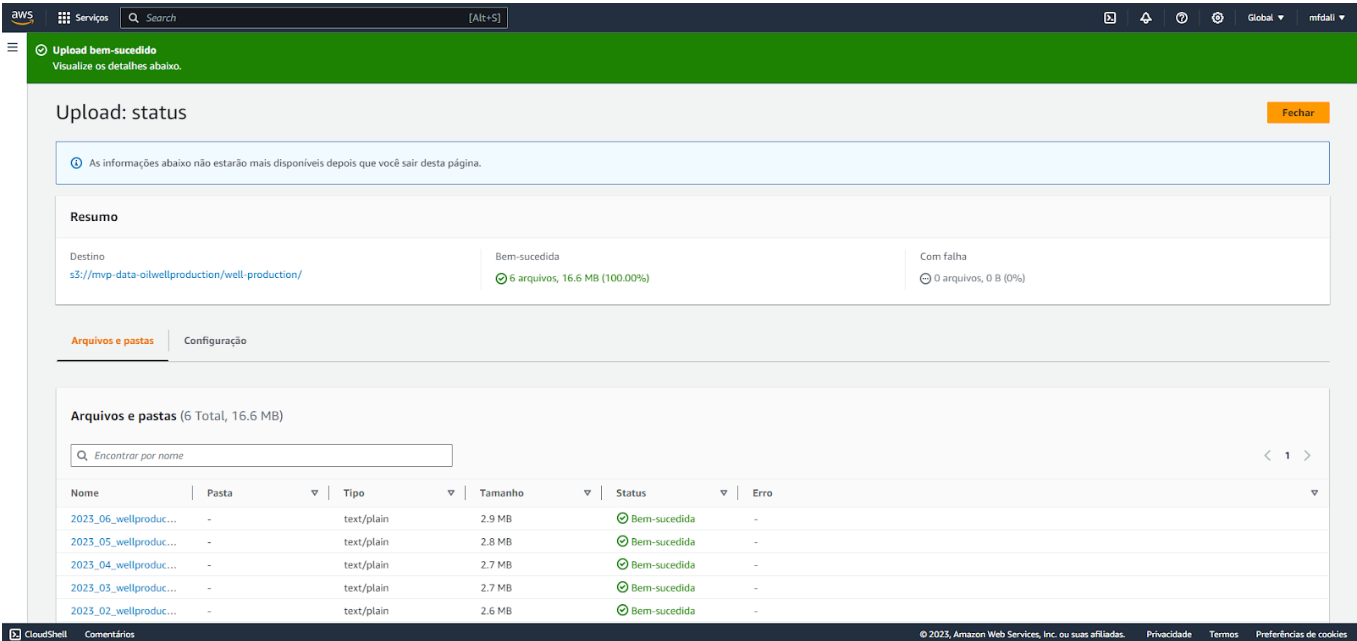

#### Glue

**Extraction**

Load S3 bucket

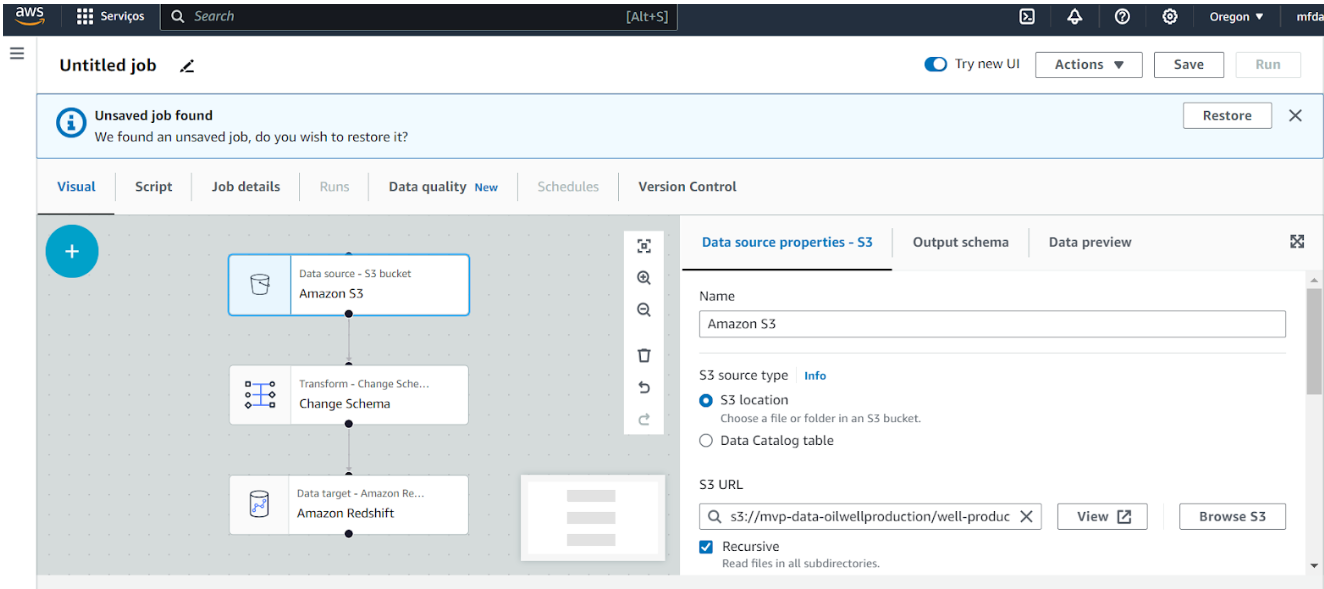

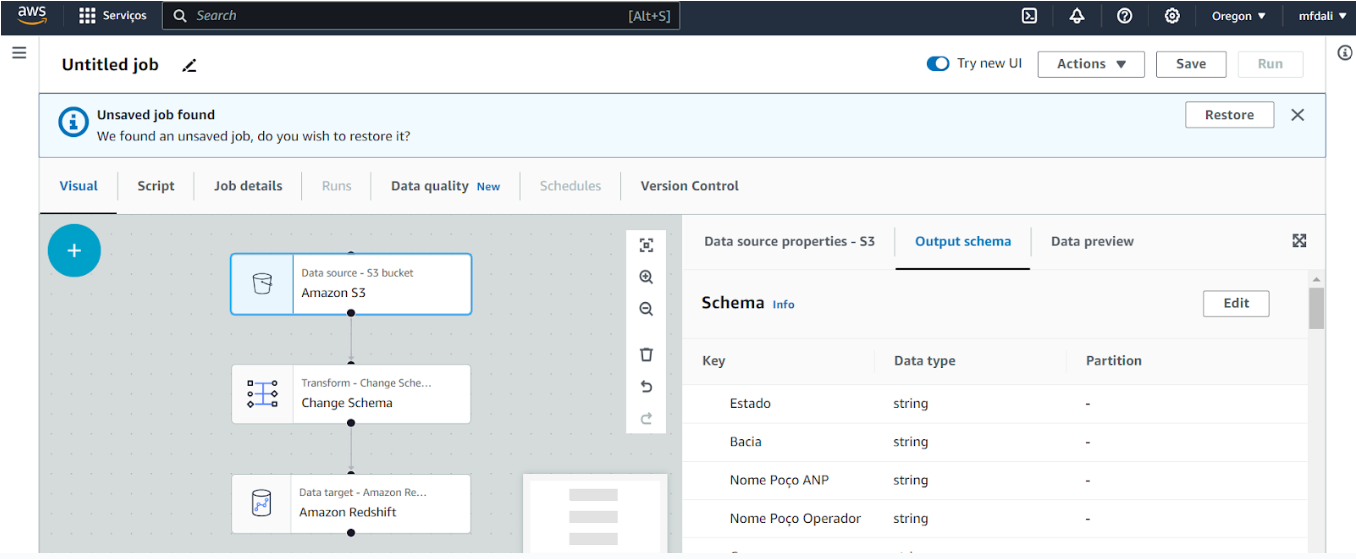

**Transform**

Change Schema

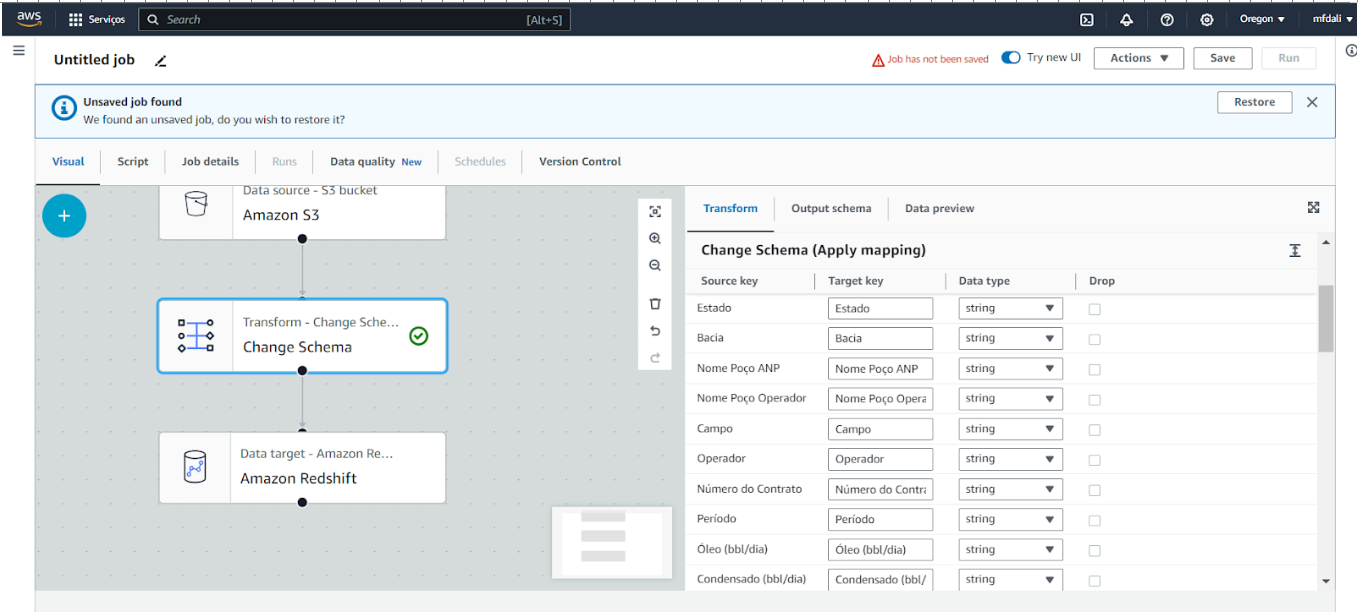

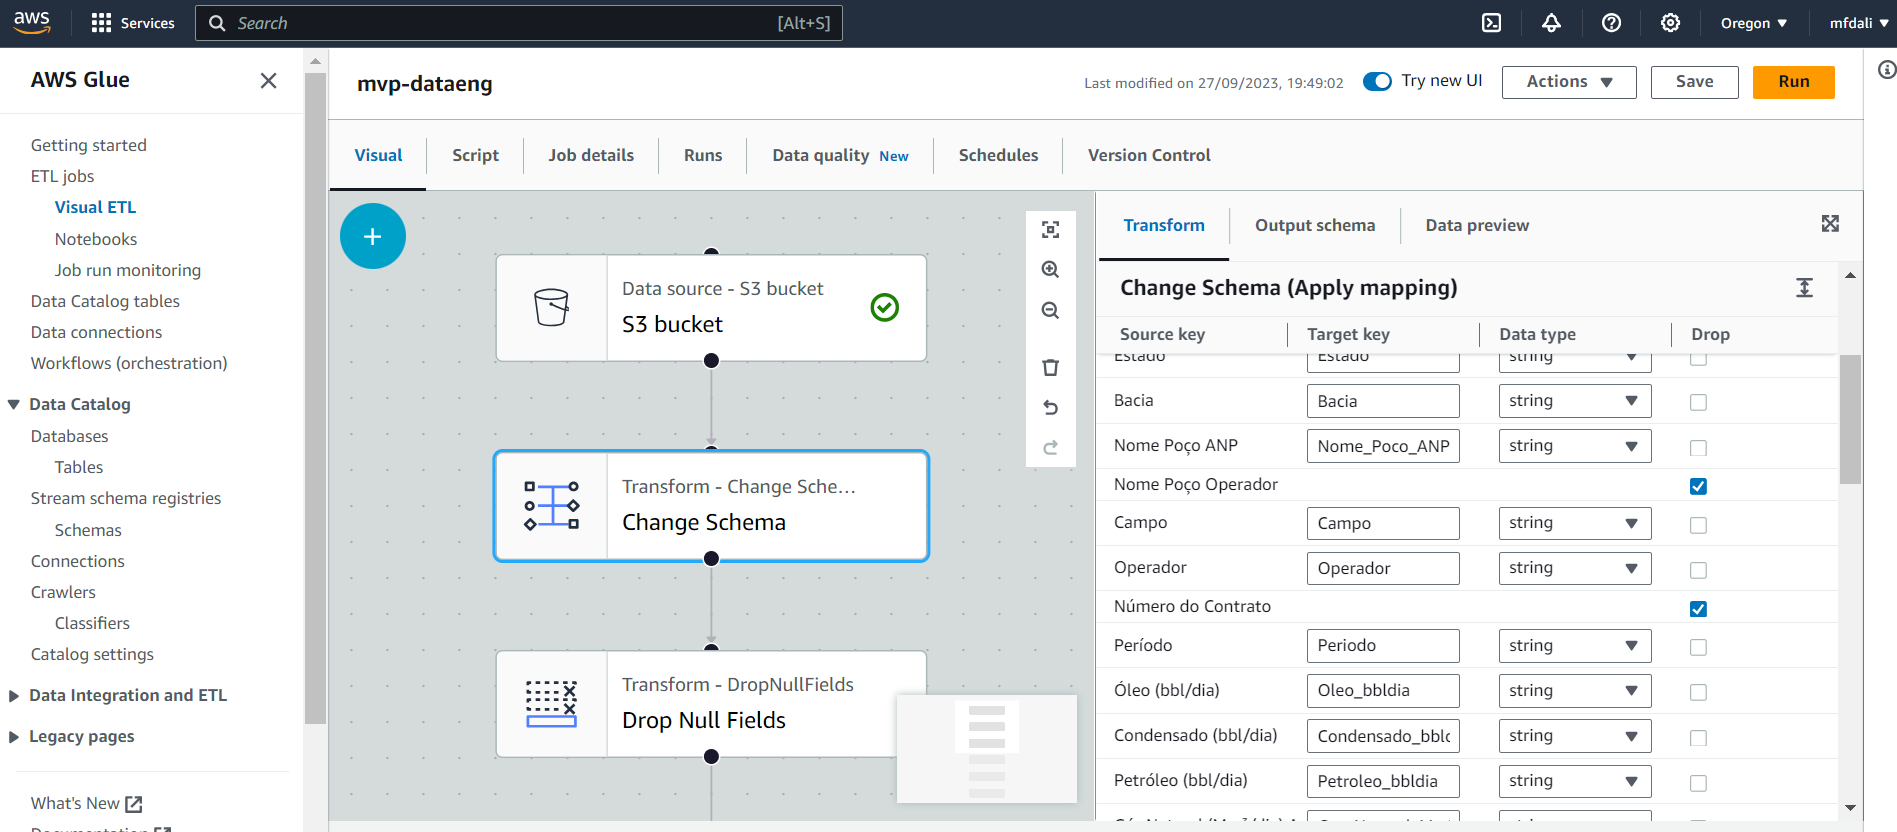

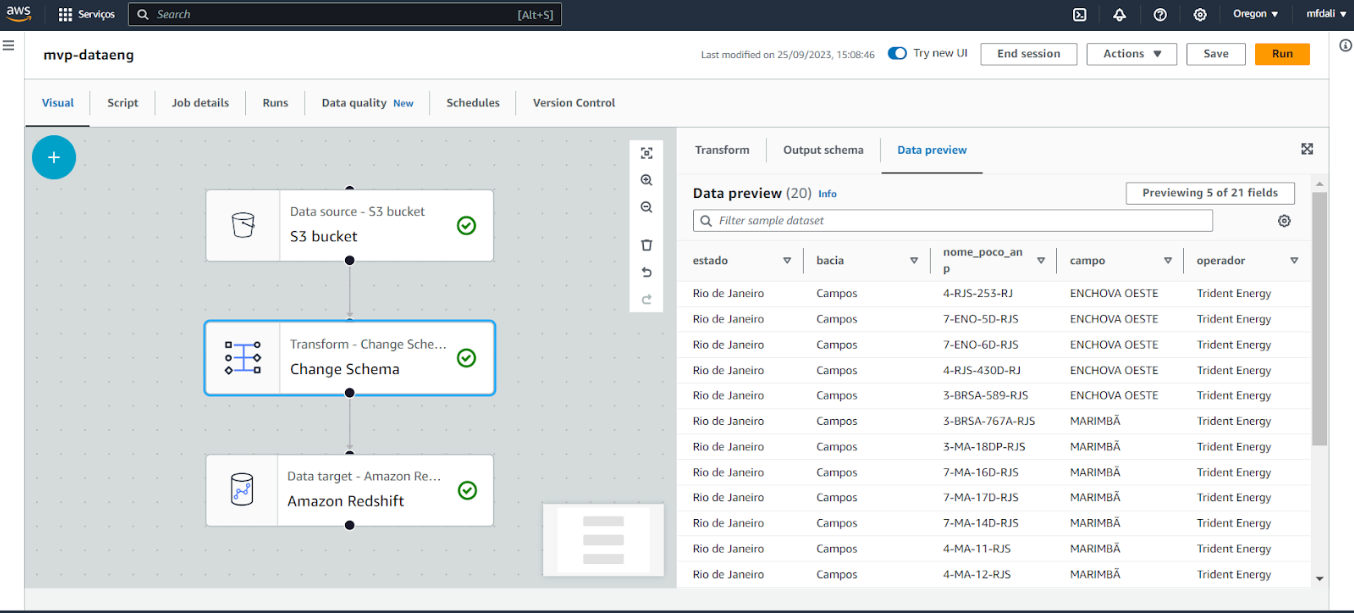

Drop Nulls

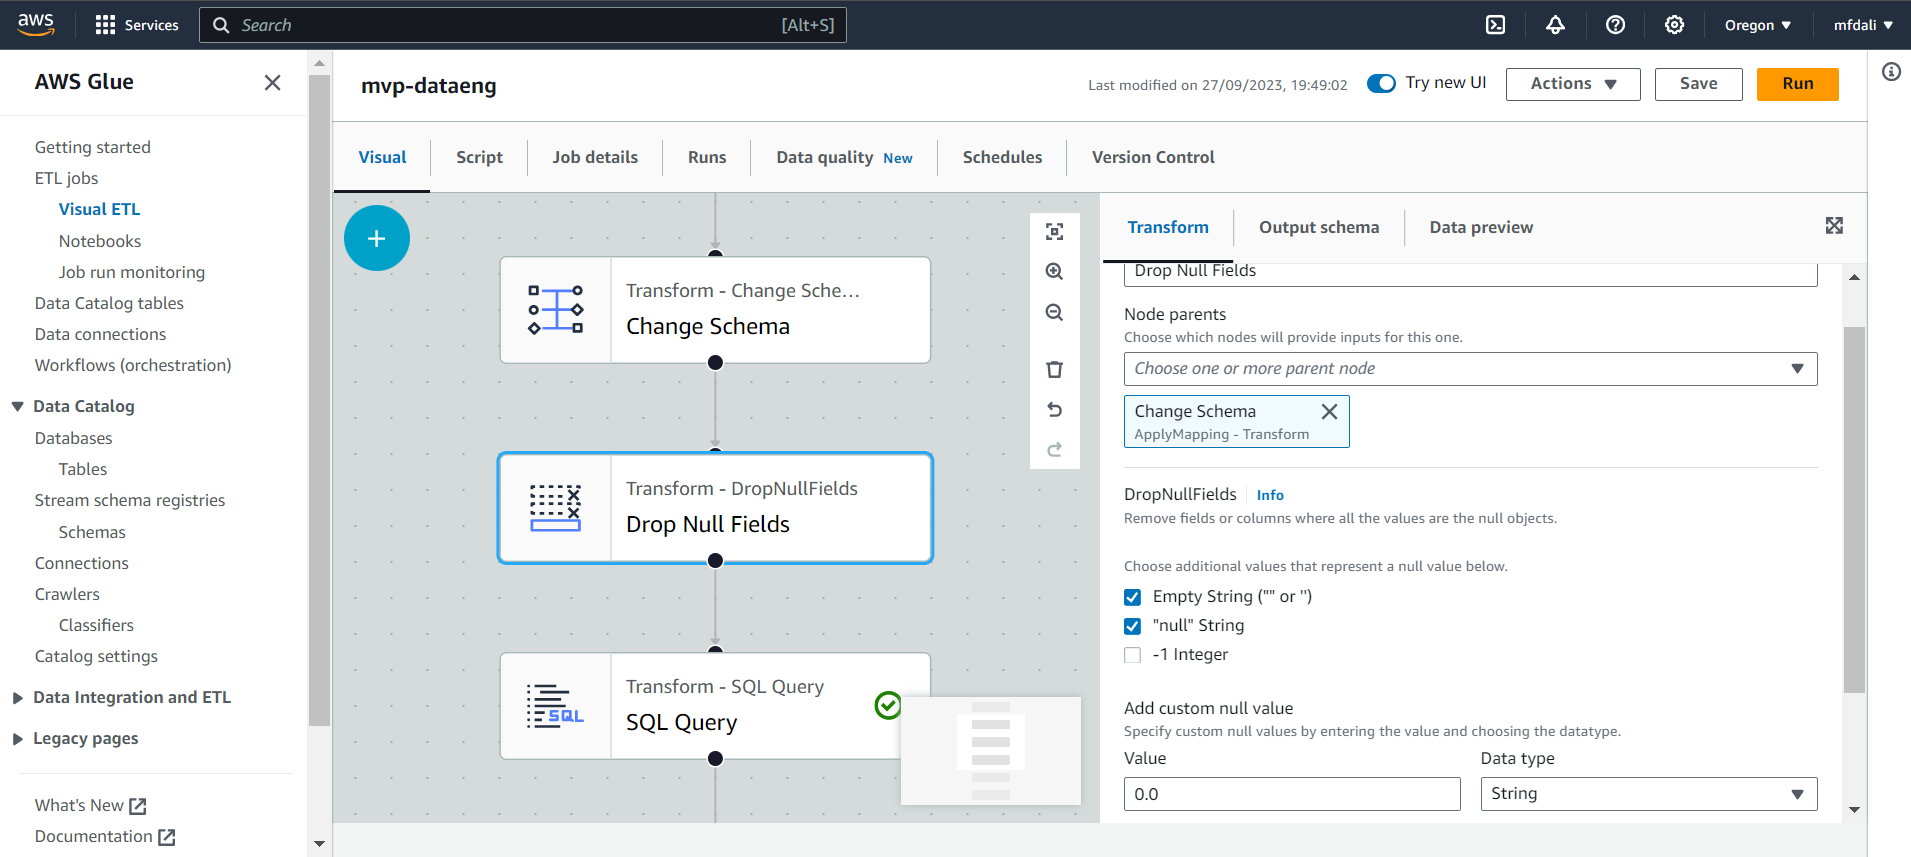

SQL Query 1

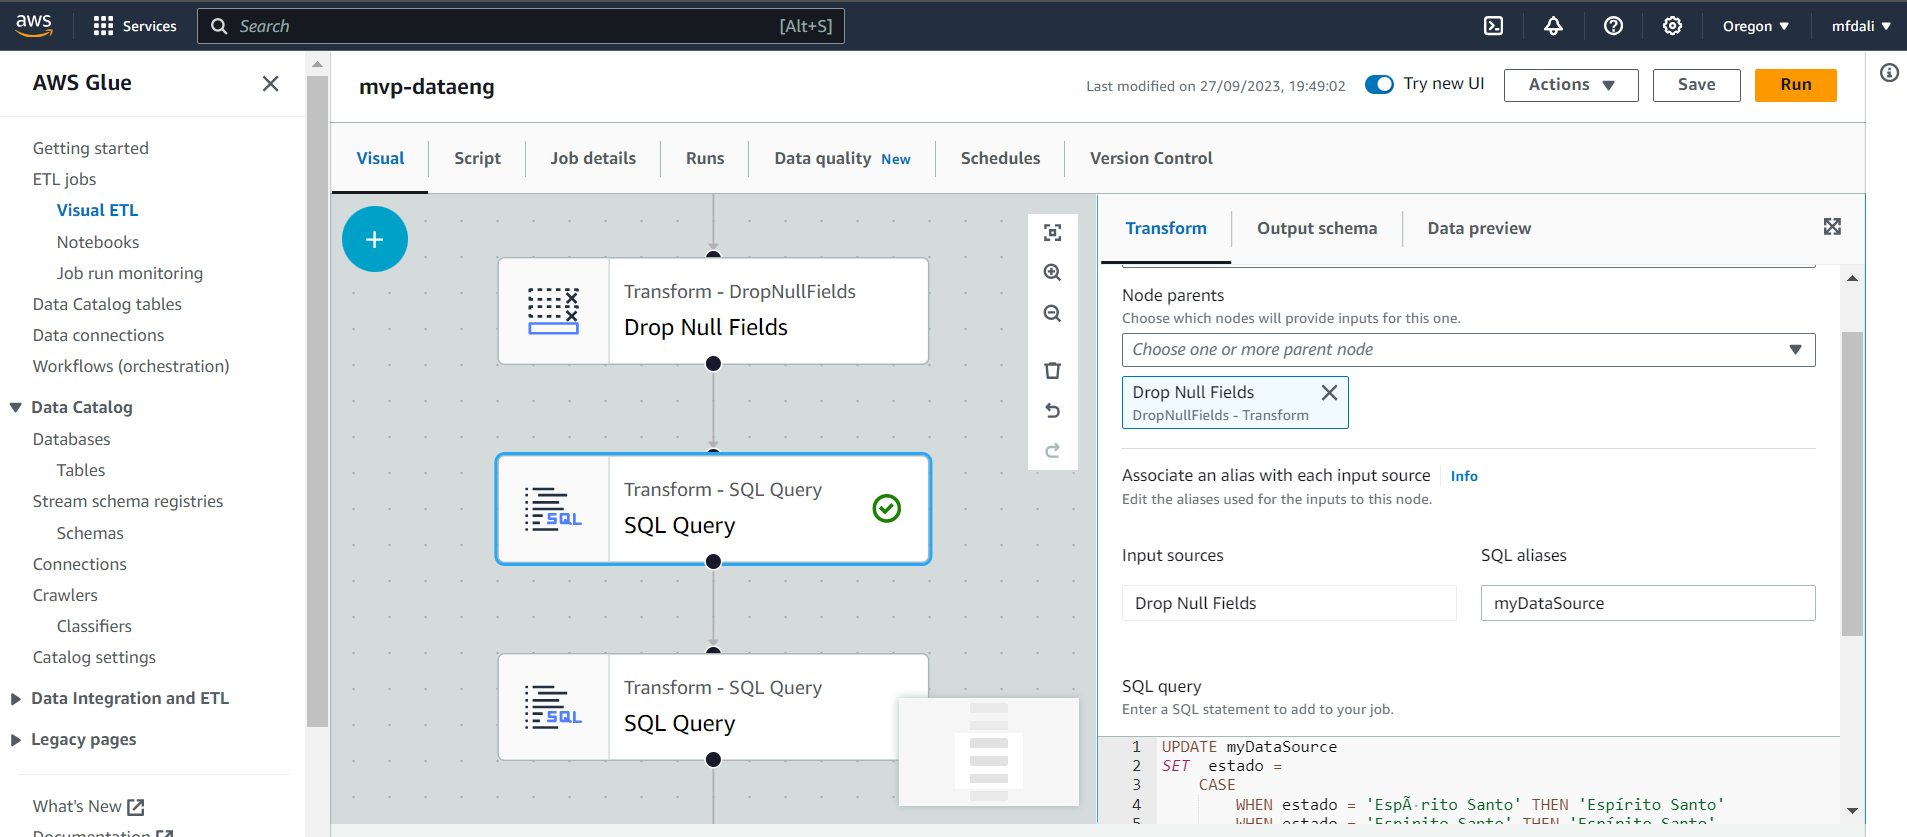

```
UPDATE wellproduction_2023
SET  estado =
    CASE
        -- Add variations and replacements
        WHEN estado = 'EspÃ­rito Santo' THEN 'Espírito Santo'
        WHEN estado = 'Espirito Santo' THEN 'Espírito Santo'
        WHEN estado = 'SÃ£o Paulo' THEN 'São Paulo'
        WHEN estado = 'Sao Paulo' THEN 'São Paulo'
        WHEN estado = 'CearÃ¡' THEN 'Ceará'
        WHEN estado = 'ParanÃ¡' THEN 'Paraná'
        WHEN estado = 'MaranhÃ£o' THEN 'Maranhão'
        ELSE estado -- If no match, keep the original value
    END
WHERE
    estado IN ('EspÃ­rito Santo', 'Espírito Santo','Espirito Santo','SÃ£o Paulo','Sao Paulo','CearÃ¡','ParanÃ¡','MaranhÃ£o'); -- Include all known variations

```

SQL Query 2

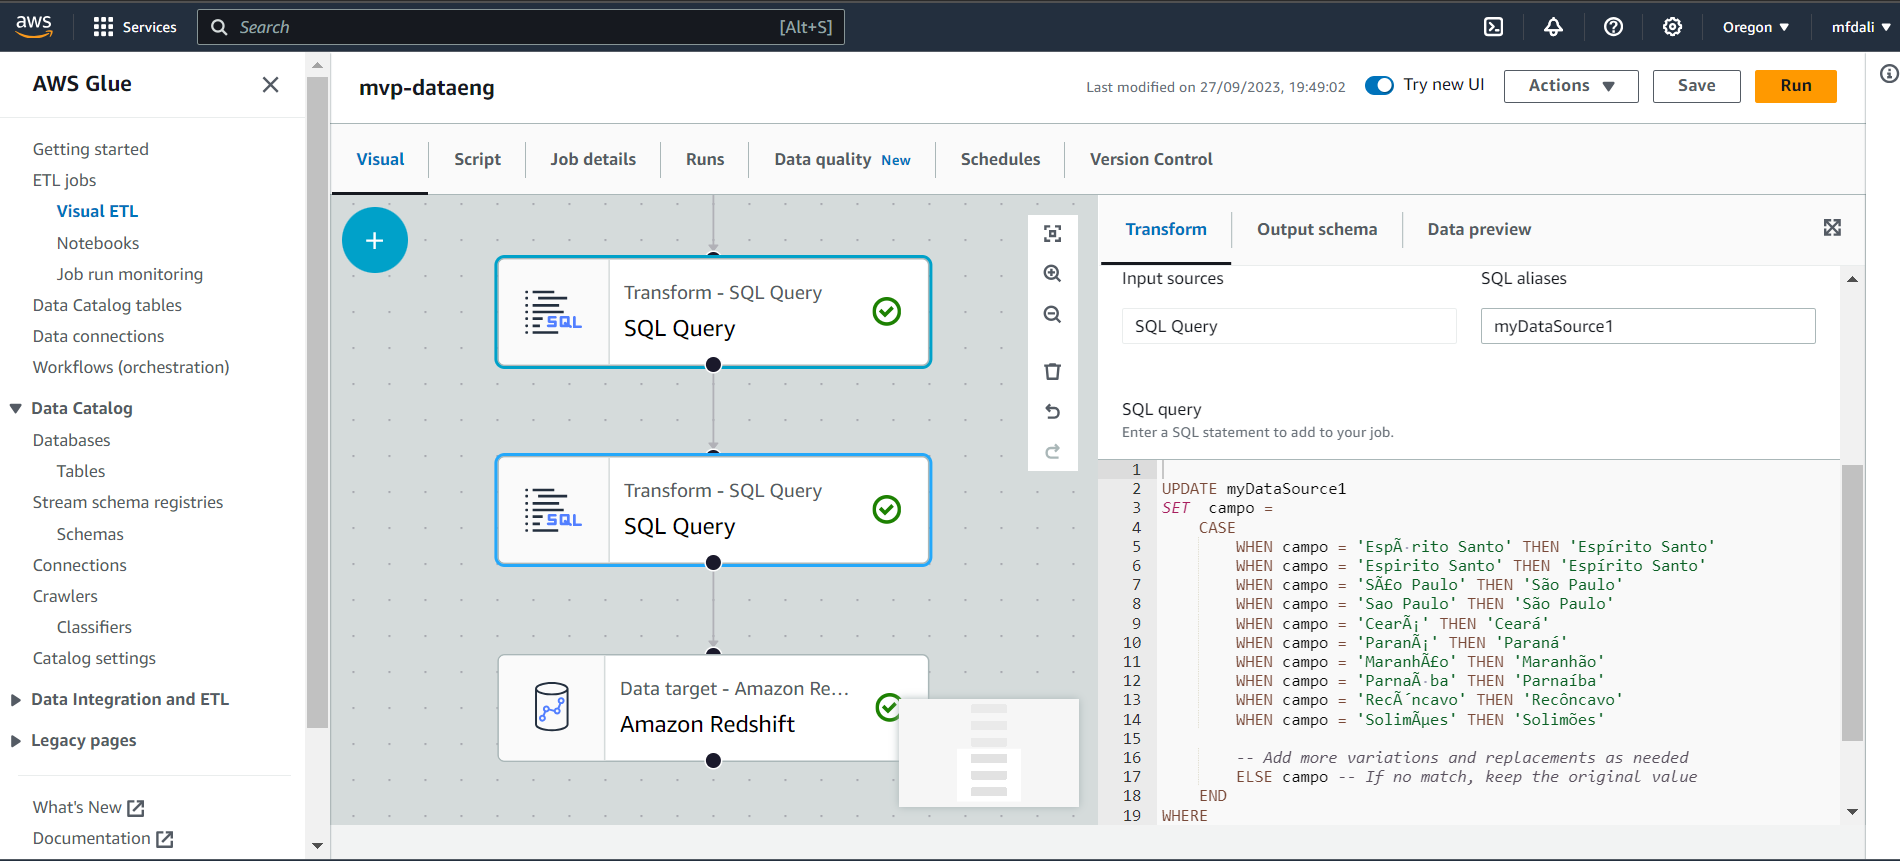

```
UPDATE wellproduction_2023
SET  campo =
    CASE
        -- Add variations and replacements
        WHEN campo = 'EspÃ­rito Santo' THEN 'Espírito Santo'
        WHEN campo = 'Espirito Santo' THEN 'Espírito Santo'
        WHEN campo = 'SÃ£o Paulo' THEN 'São Paulo'
        WHEN campo = 'Sao Paulo' THEN 'São Paulo'
        WHEN campo = 'CearÃ¡' THEN 'Ceará'
        WHEN campo = 'ParanÃ¡' THEN 'Paraná'
        WHEN campo = 'MaranhÃ£o' THEN 'Maranhão'
        WHEN campo = 'ParnaÃ­ba' THEN 'Parnaíba'
        WHEN campo = 'RecÃ´ncavo' THEN 'Recôncavo'
        WHEN campo = 'SolimÃµes' THEN 'Solimões'
        ELSE campo -- If no match, keep the original value
    END
WHERE
    campo IN ('EspÃ­rito Santo', 'Espírito Santo','Espirito Santo','SÃ£o Paulo','Sao Paulo','CearÃ¡','ParanÃ¡','MaranhÃ£o','ParnaÃ­ba','RecÃ´ncavo','SolimÃµes'); -- Include all known variations
```

**Connections**

Create connection

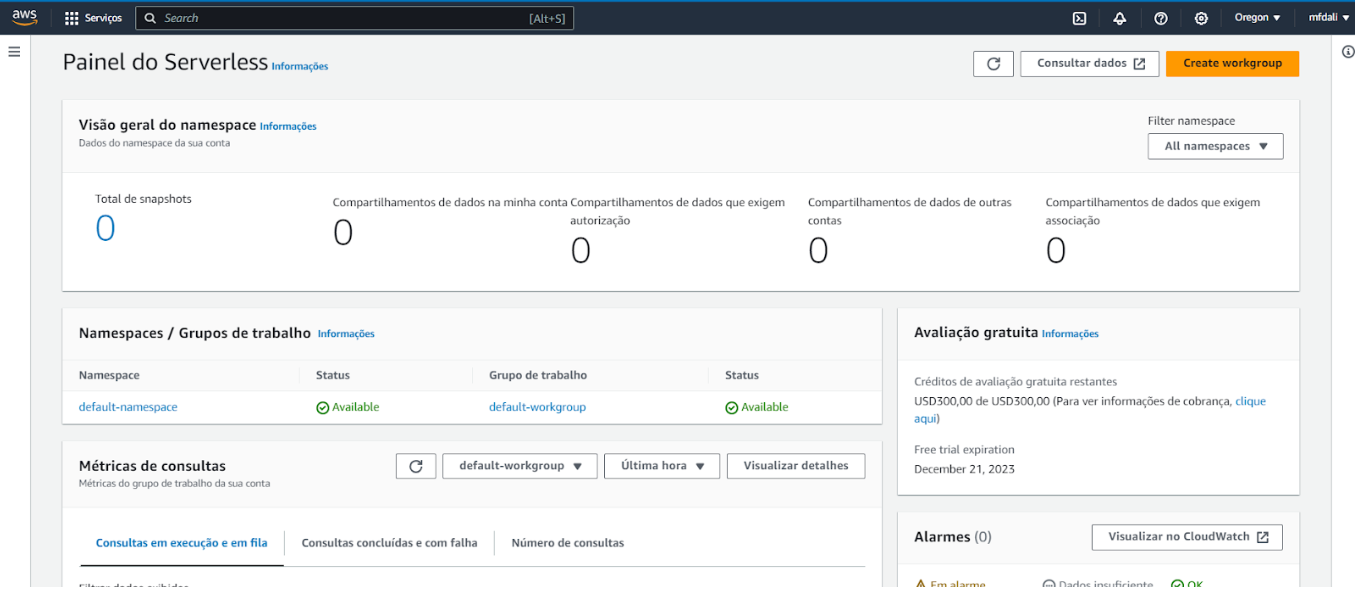

IAM role

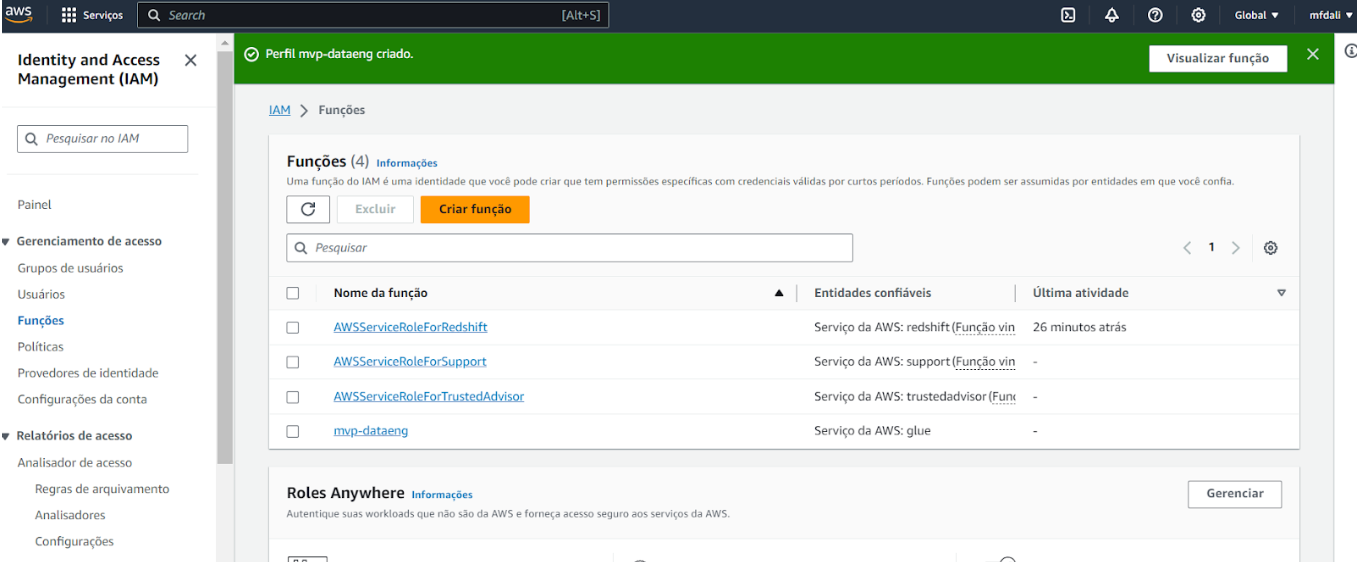

Connection Glue to Redshift

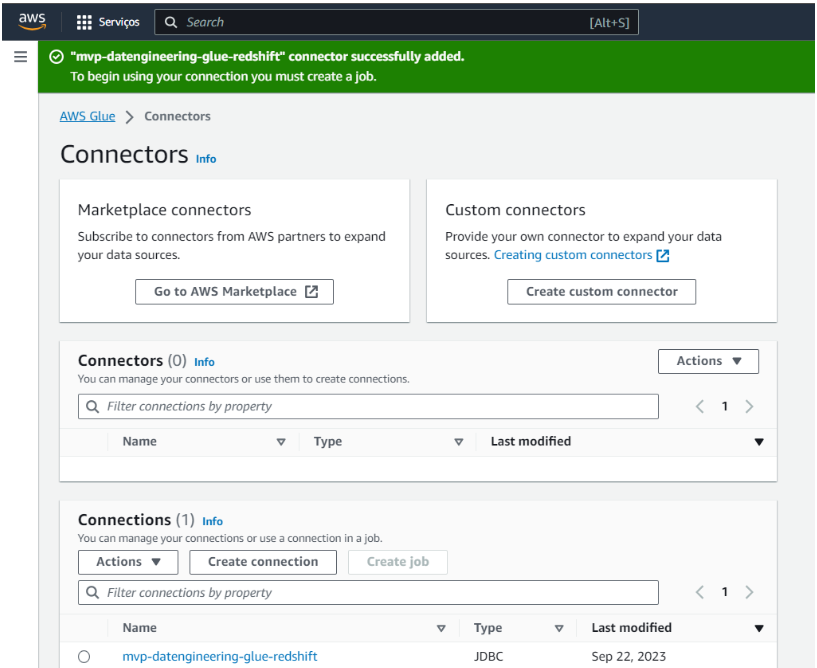

VPC endpoint

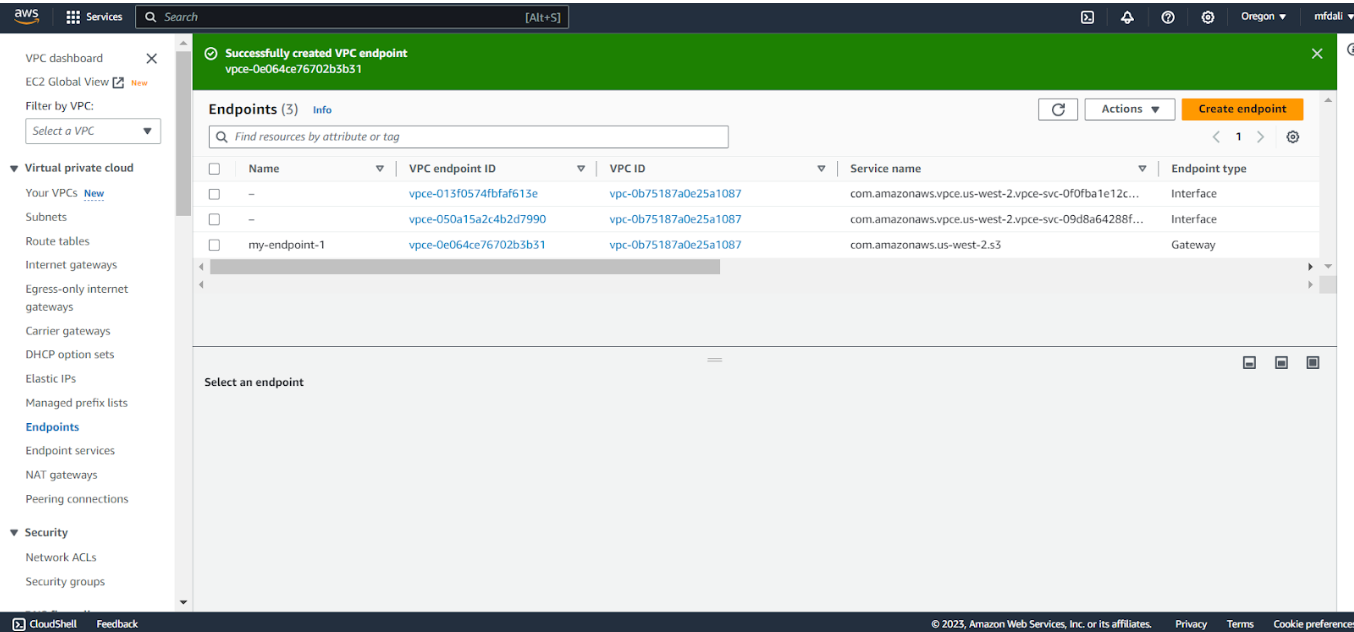

Test connection

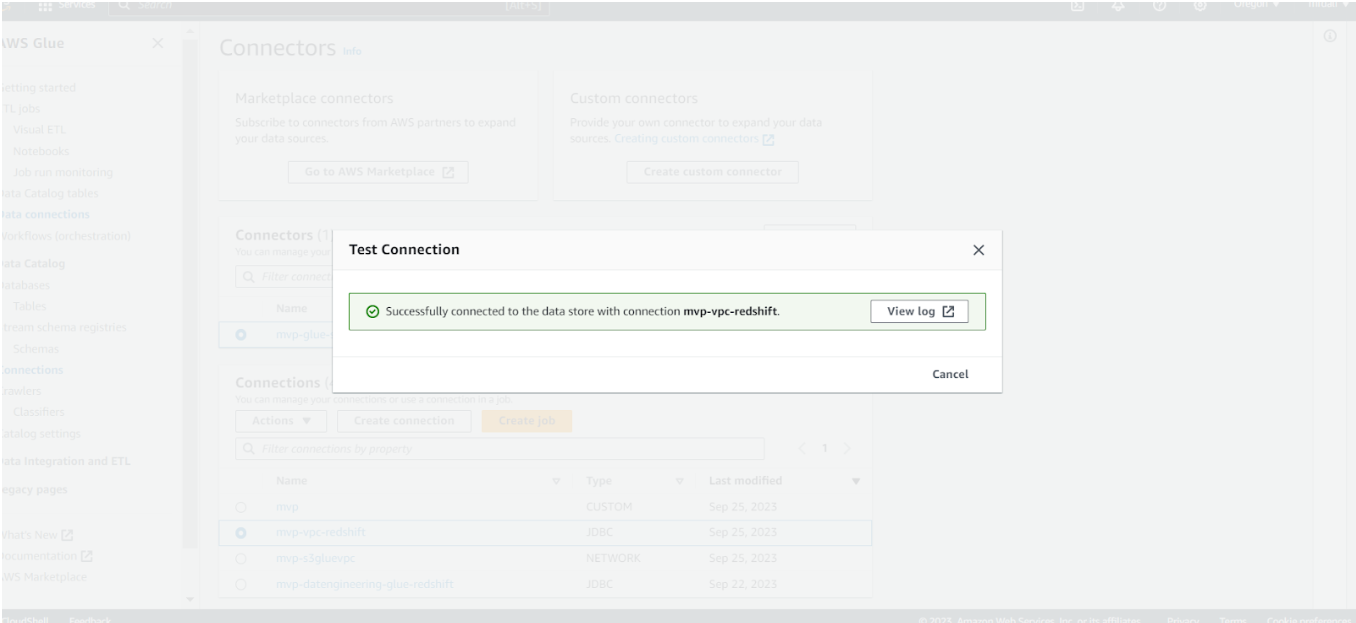

**Load**

Target to Redshift

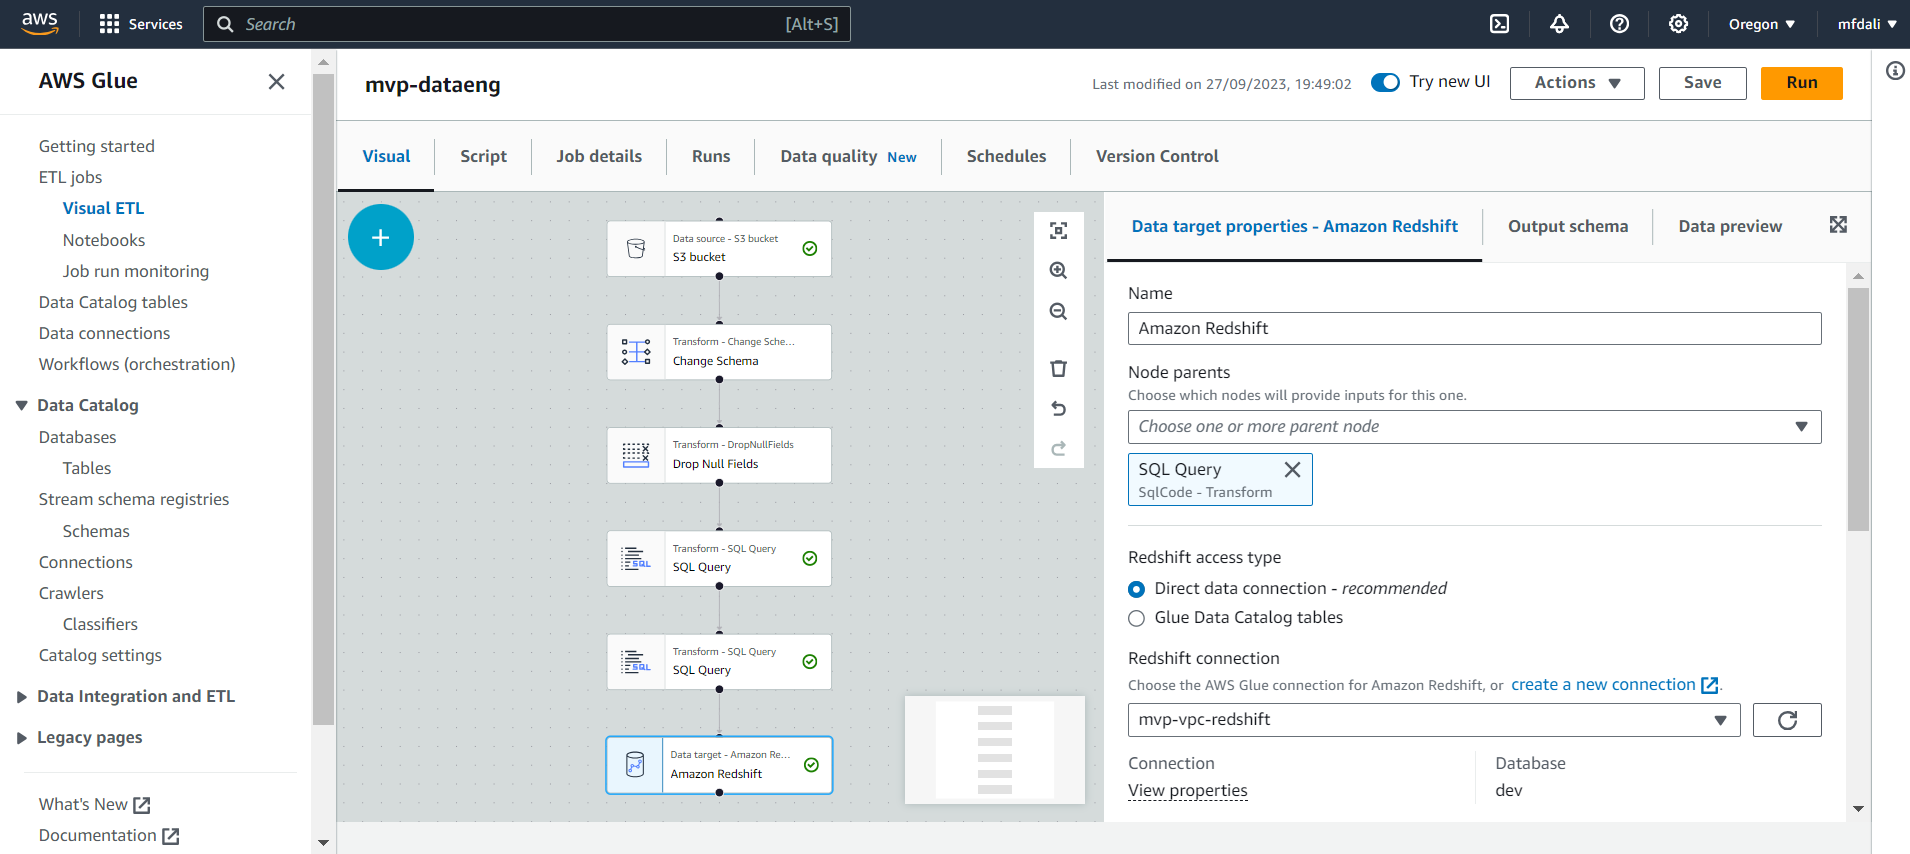

Create table in Redshift

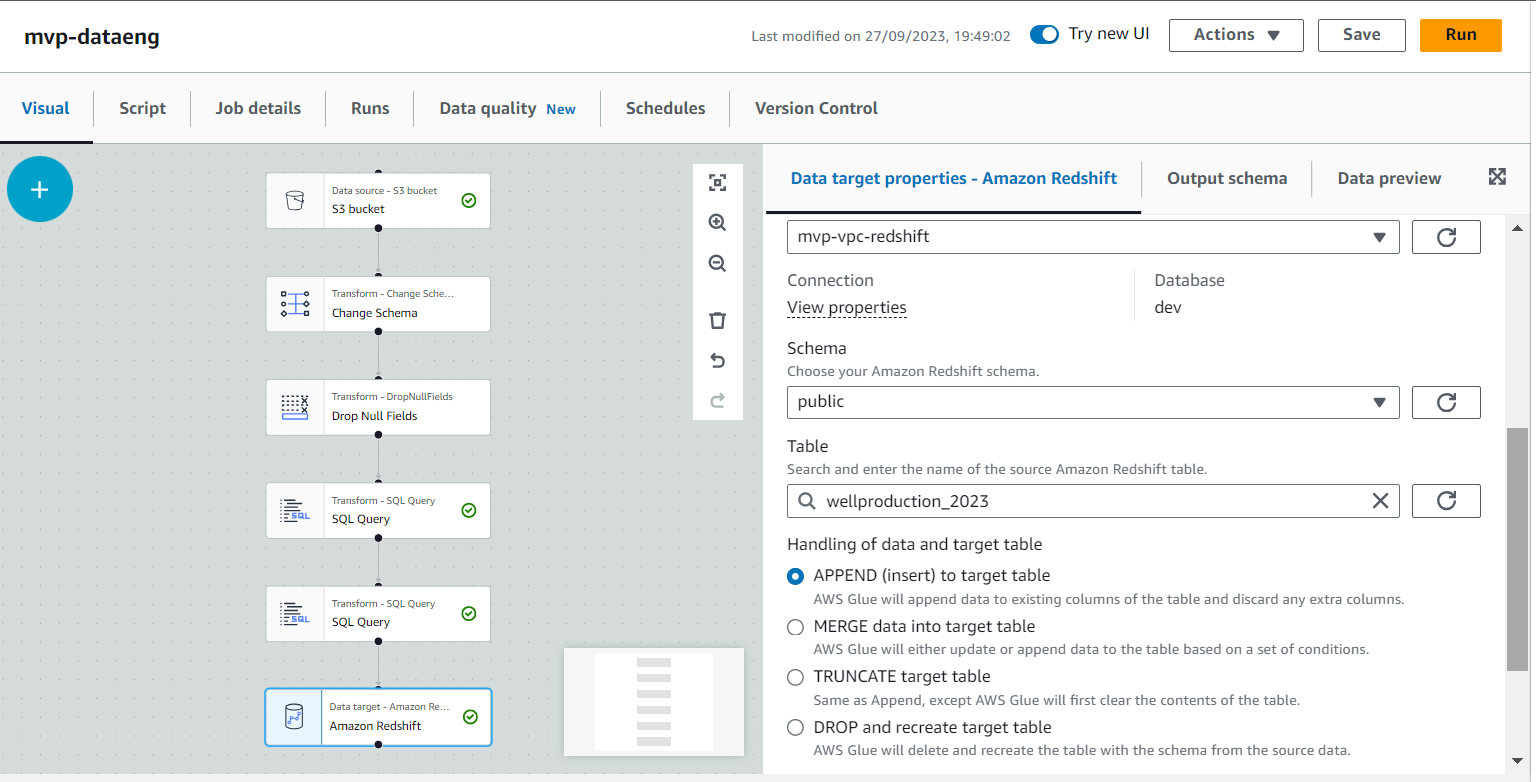

**Run Job**

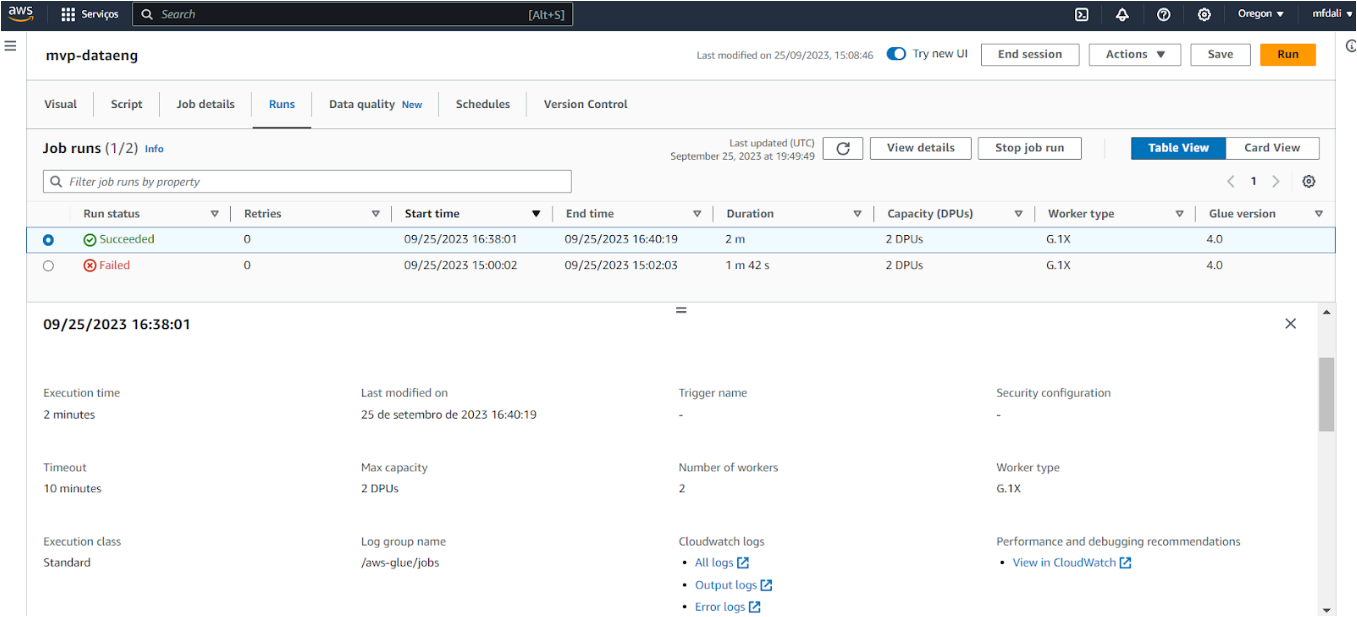

#### Redshift

**Query data in Redshift**

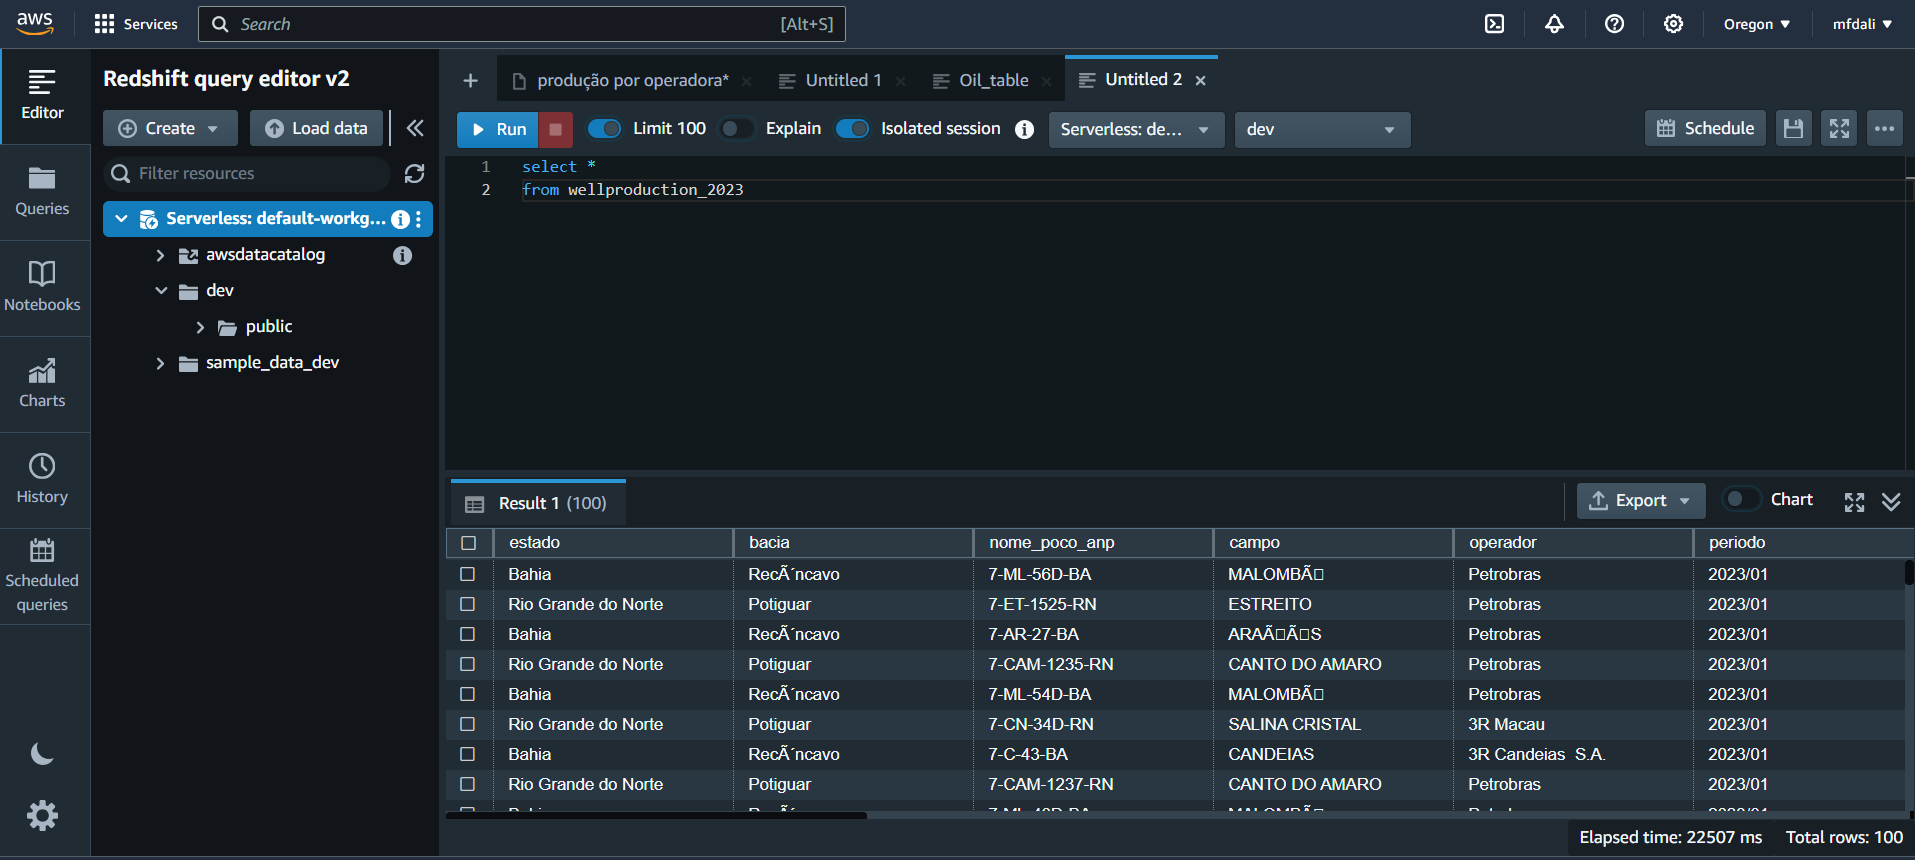

## Data Analysis

**Questions**
1. What is the crude oil production of brazil accumulated in 2023?
2. What was the oil production per month?
2. What is the crude oil production accumulated per well location?
4. What are the top companies in oil production in 2023 with total number of wells and average oil production per well?
5. What is the most productive state?
6. What is the most productive field?
7. What is the most productive well?

Water is an undesirable subproduct of oil extraction. Water injection is widely used as secondary recovery method in wells. However, it is not good to produce water in high levels. Mature wells have oil production curve in decline.

8. What is the worst state in terms of crude oil extraction efficience?
9. In which state are located the worst fields in efficience?
10. What are the 10 most inneficient wells?


1. What is the crude oil production of brazil accumulated in 2023?

40,260,914 bbl

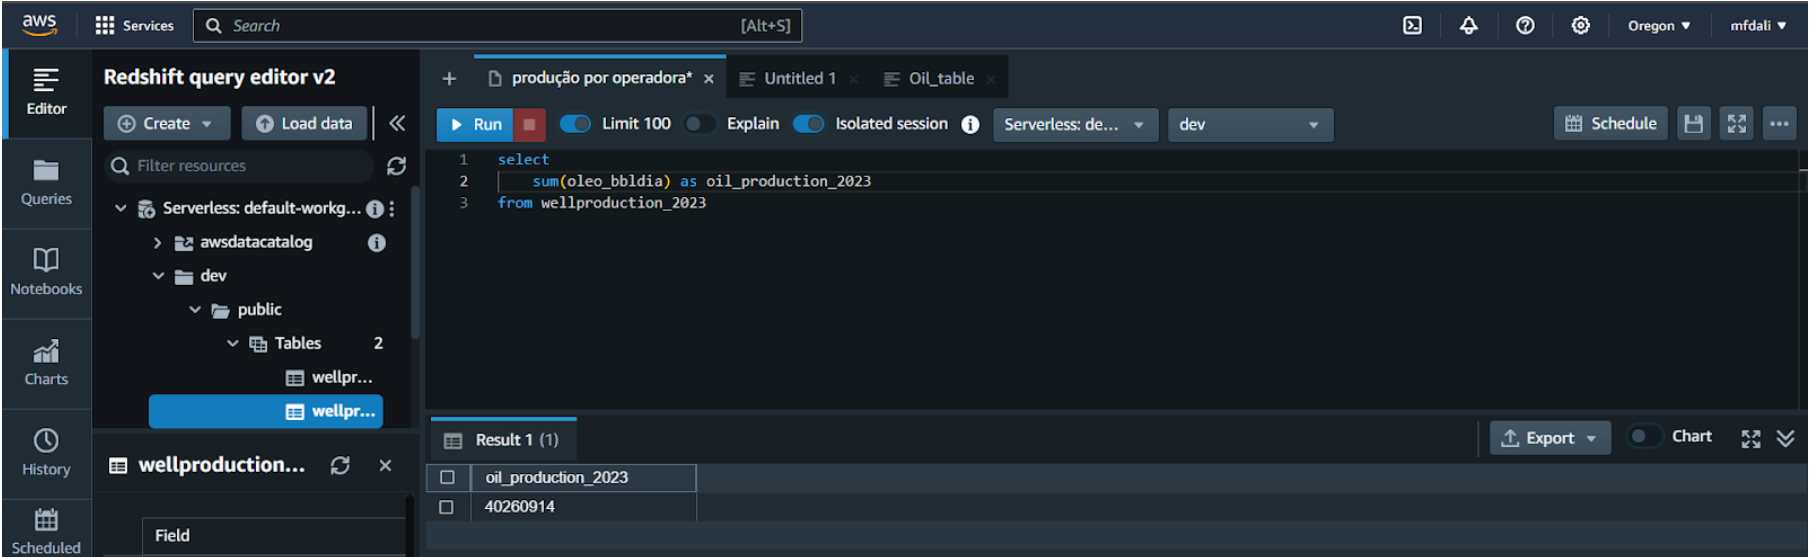

2. What was the oil production per month?

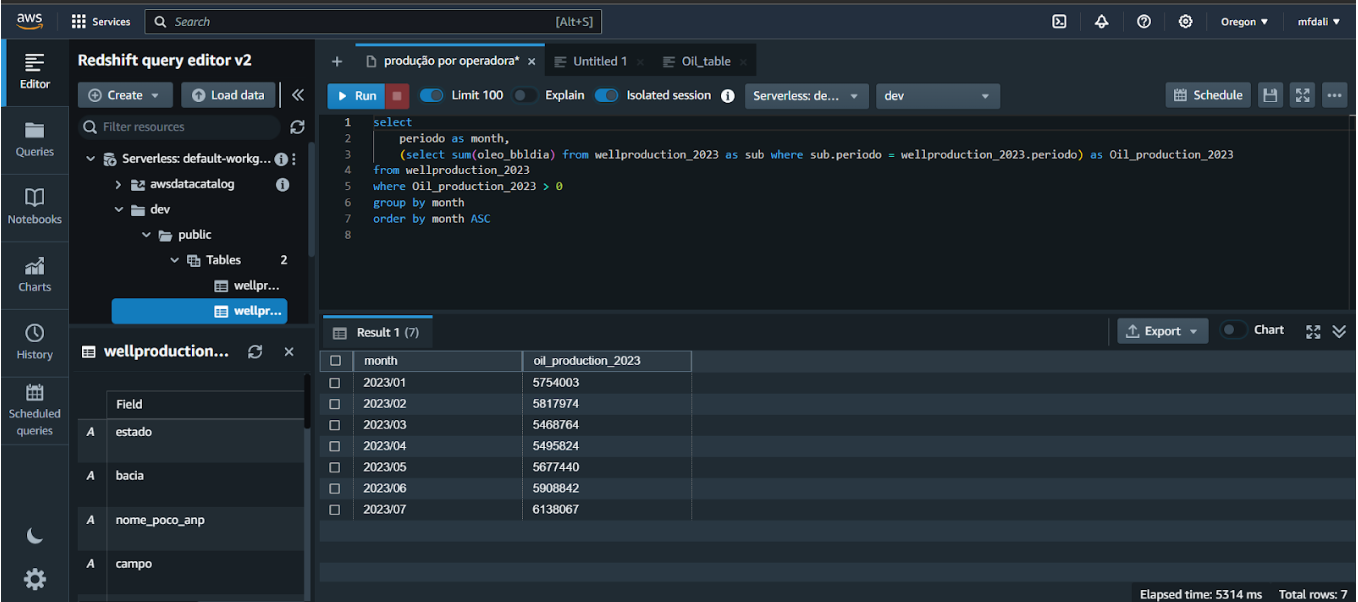

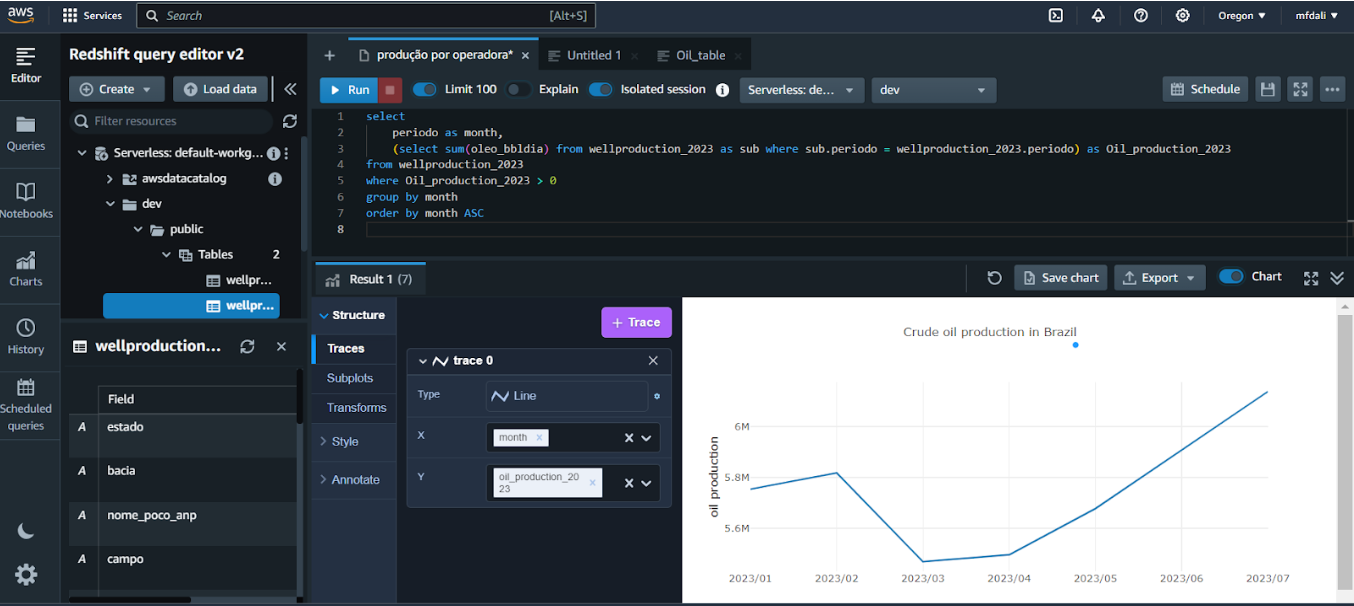

3. What is the crude oil production accumulated per well location?

Most part of crude oil is extracted offshore

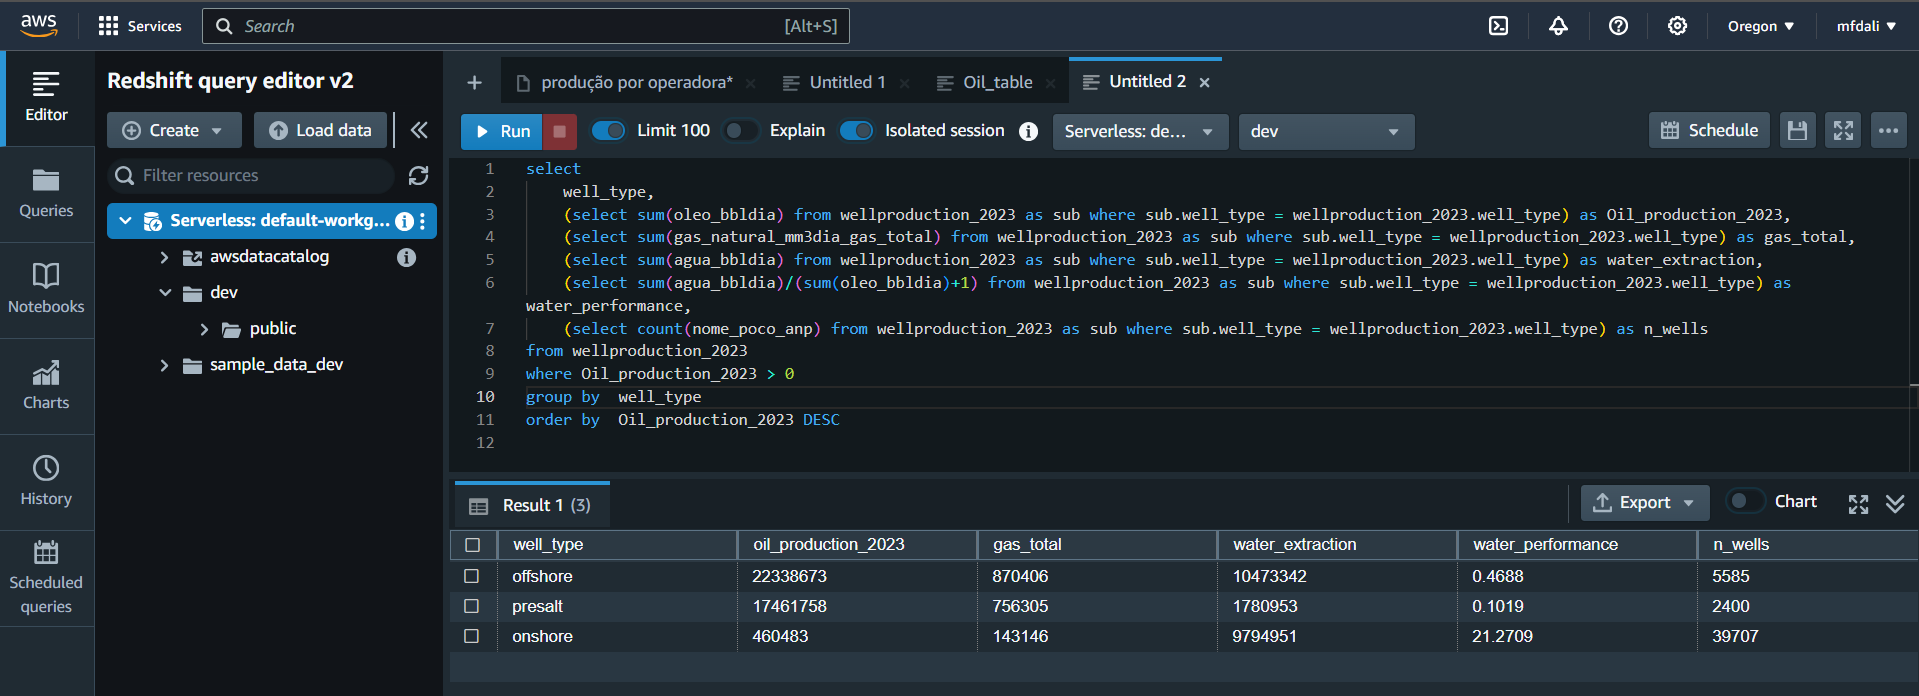

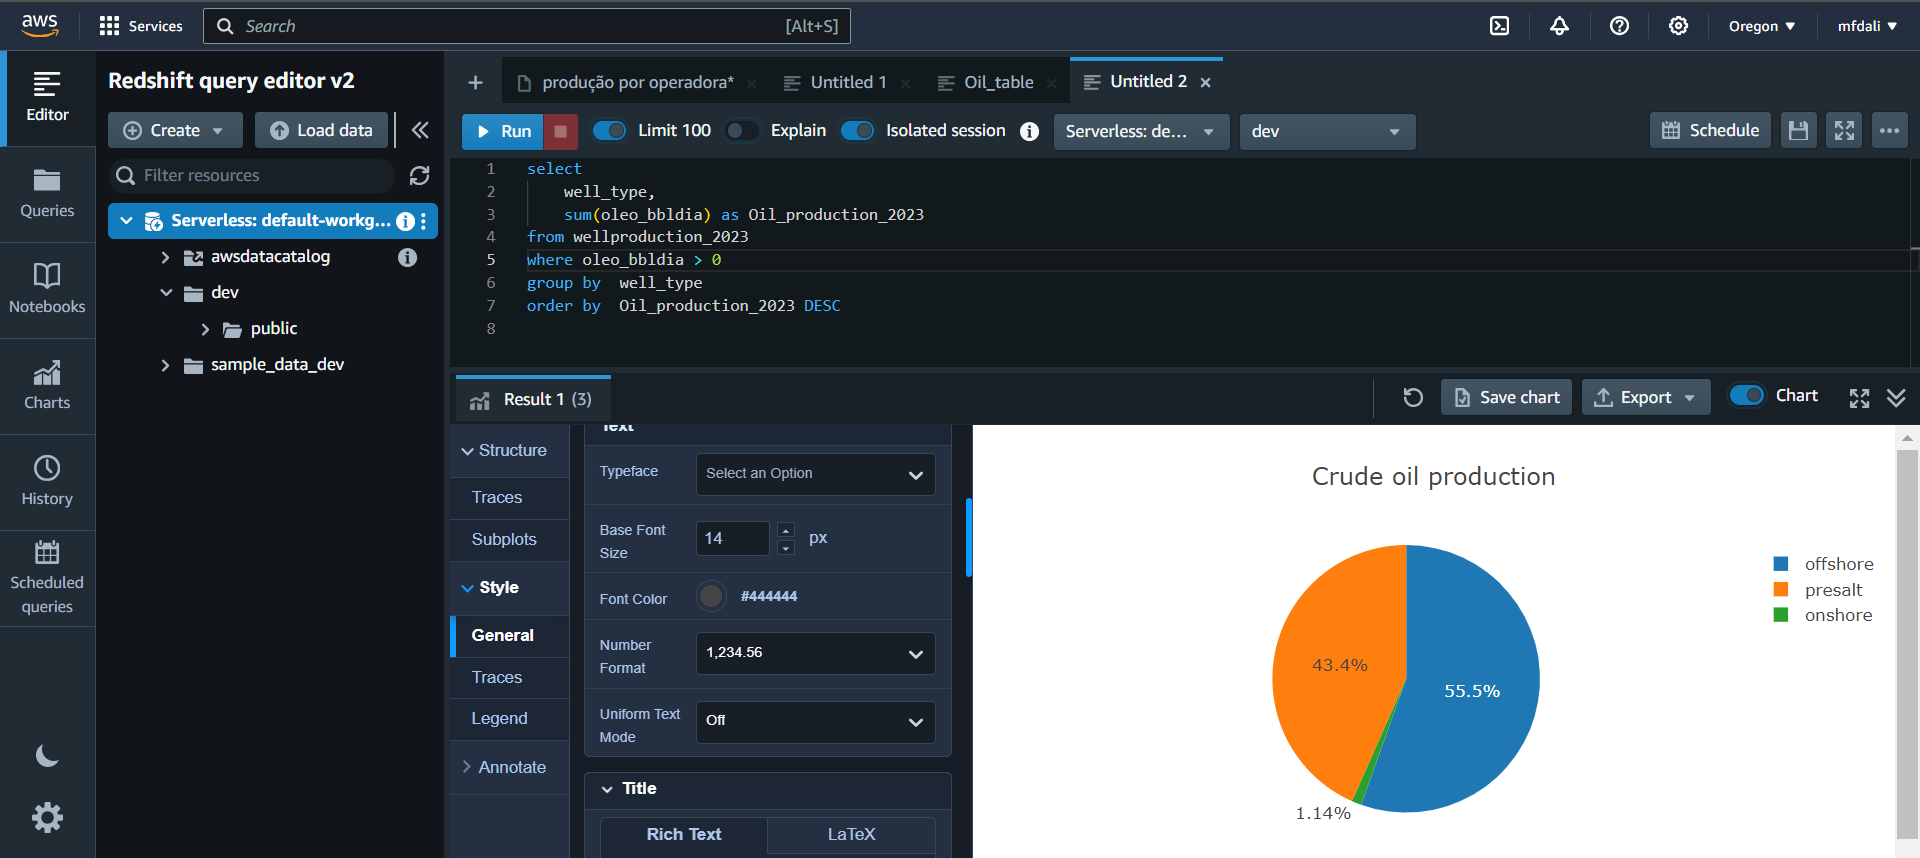

4. What are the top companies in oil production in 2023 with total number of wells and average oil production per well?

Petrobras is the company with highest crude oil extraction, followed by Total and Equinor.

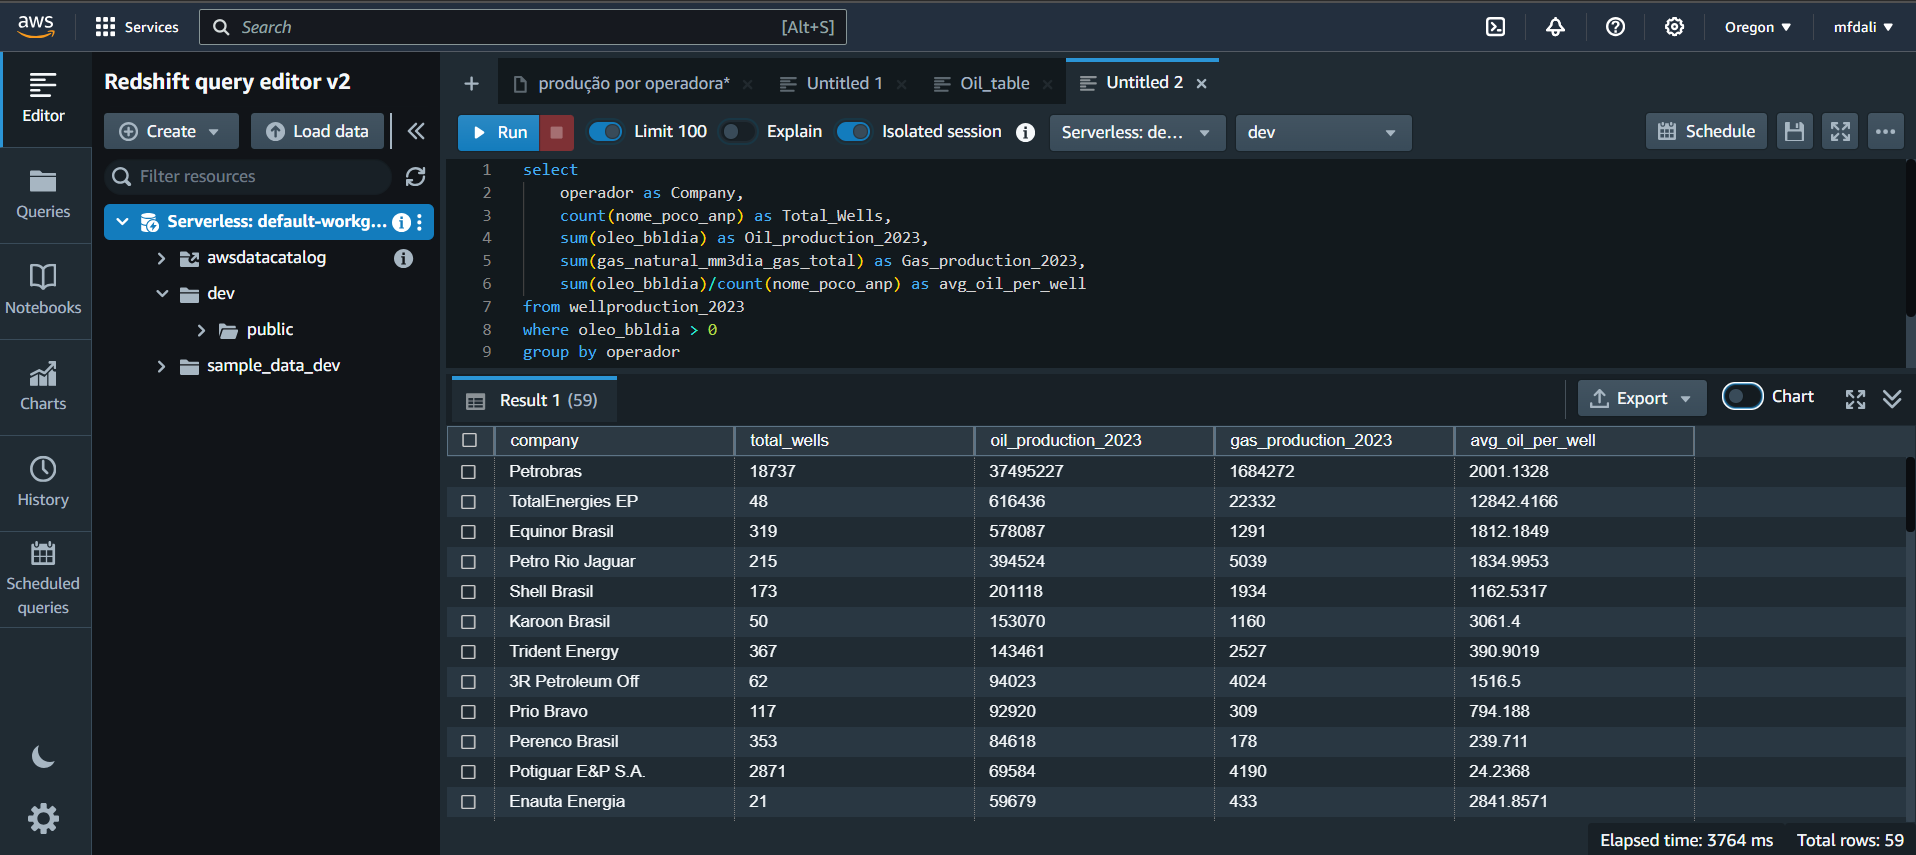

5. What is the most productive state?

Rio de Janeiro is the most productive state

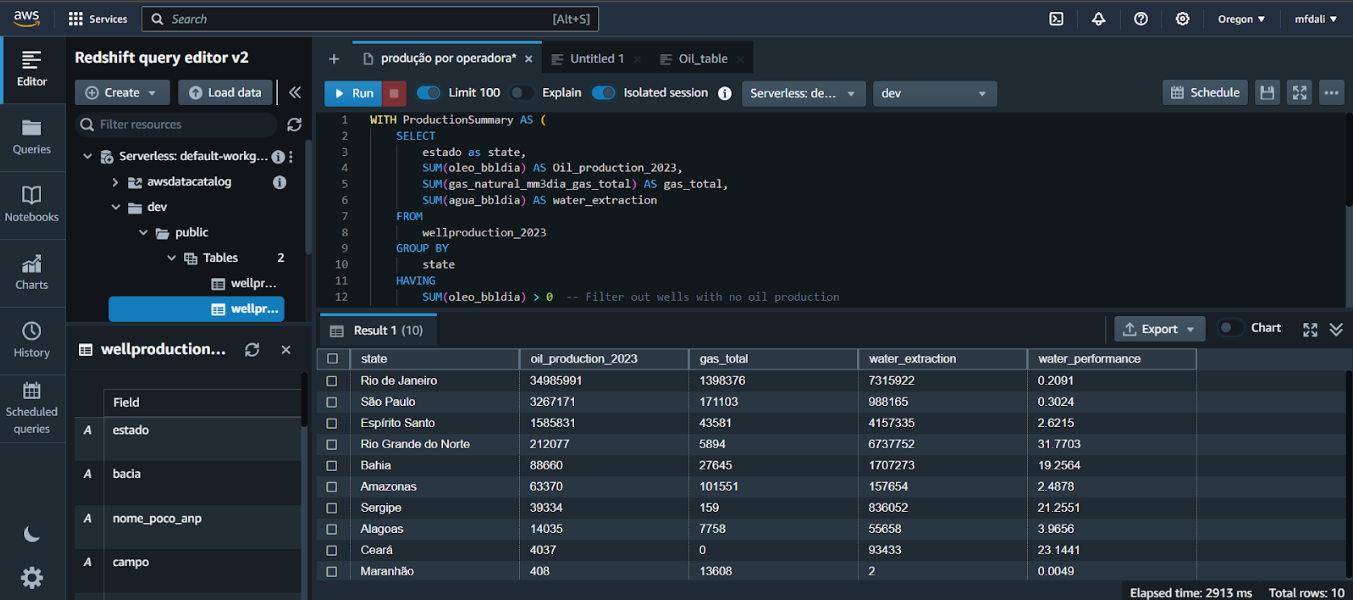

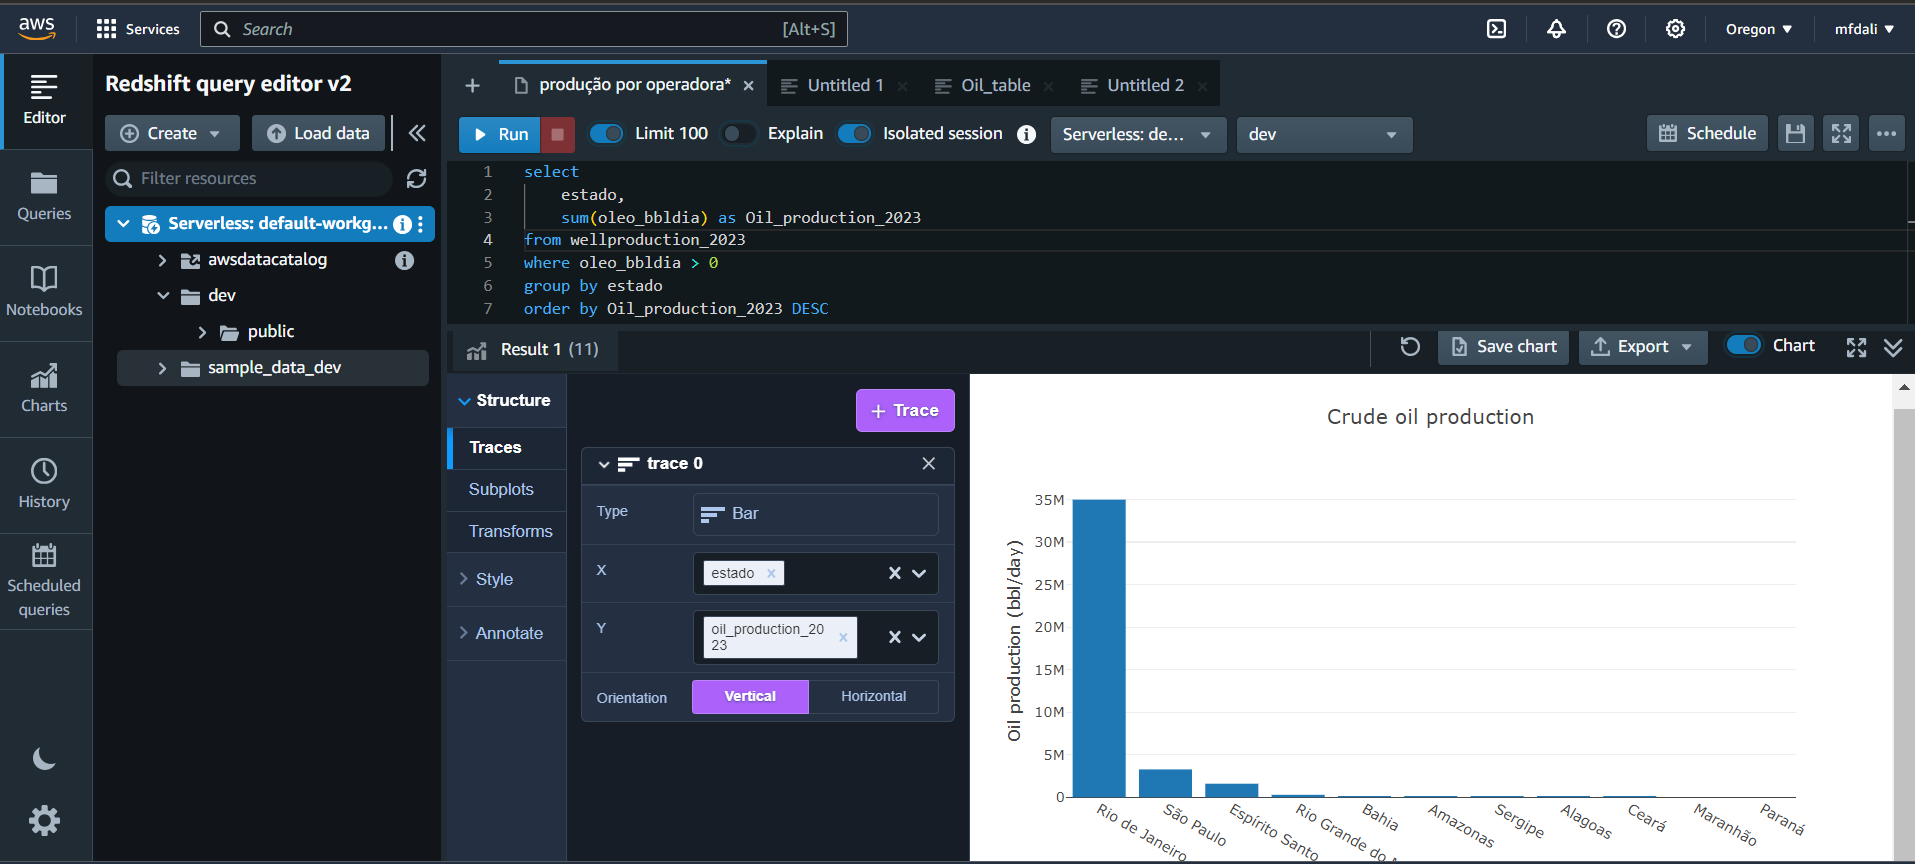

6. What is the most productive field?

According with this dataset, Tupi field is the most productive

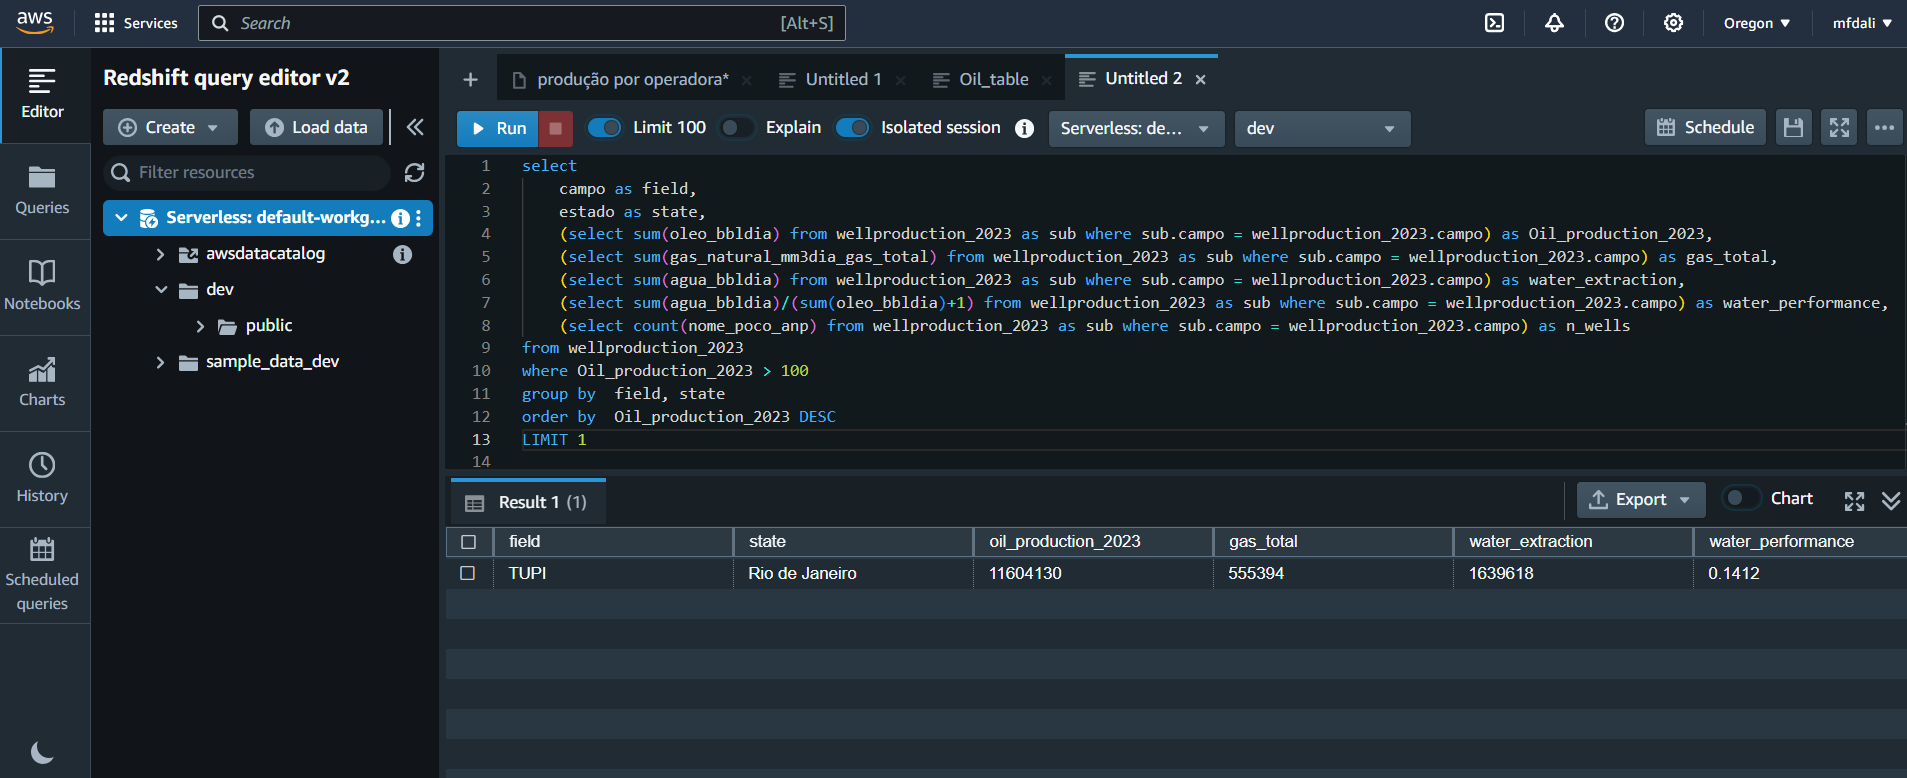

7. What is the most productive well?

1-BRSA-1116-RJS is the first well in crude oil extraction. This well is explored by Petrobras and is located in Rio de Janeiro State.

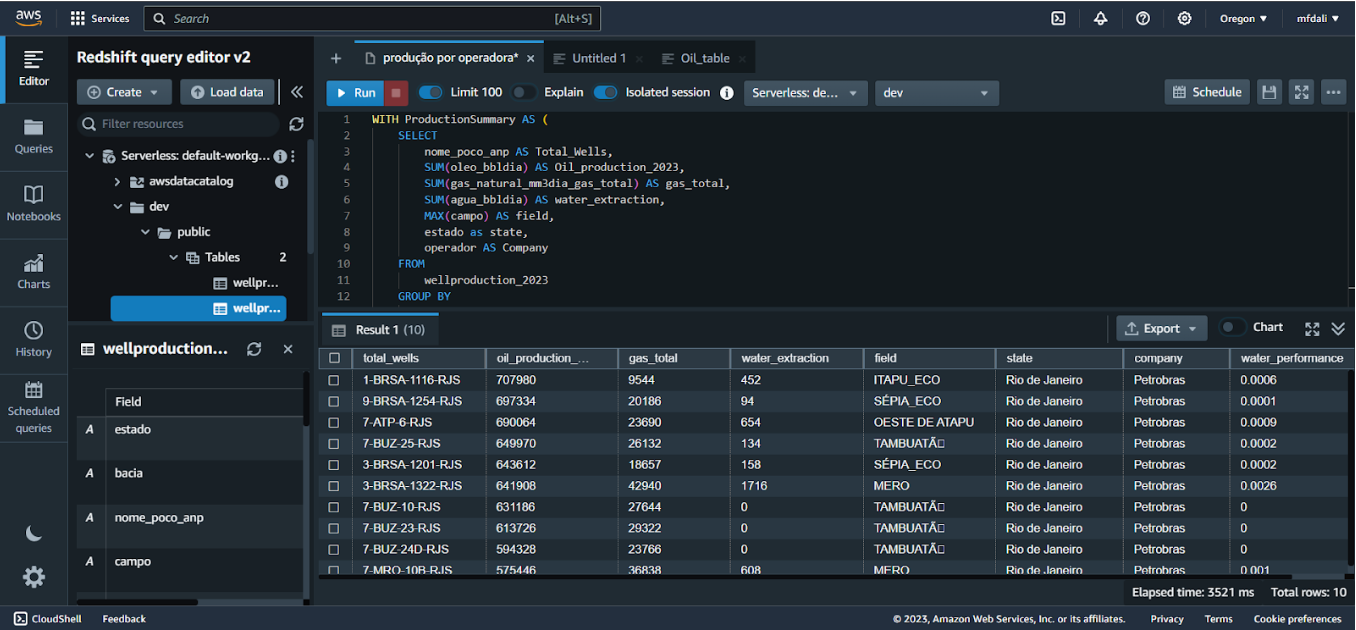

```
WITH ProductionSummary AS (
    SELECT
        nome_poco_anp AS Total_Wells,
        SUM(oleo_bbldia) AS Oil_production_2023,
        SUM(gas_natural_mm3dia_gas_total) AS gas_total,
        SUM(agua_bbldia) AS water_extraction,
        MAX(campo) AS field,
        estado as state,
        operador AS Company
    FROM
        wellproduction_2023
    GROUP BY
        nome_poco_anp, state, company
    HAVING
        SUM(oleo_bbldia) > 100  -- Filter out wells with no oil production
)
SELECT
    Total_Wells,
    Oil_production_2023,
    gas_total,
    water_extraction,
    field,
    state,
    Company,
    (water_extraction / Oil_production_2023) AS water_performance
FROM
    ProductionSummary
ORDER BY
    Oil_production_2023 DESC
LIMIT 10

```

**Water production**

8. What is the worst state in terms of crude oil extraction efficience?

Rio Grande do Norte has the highest water rate production. This state is followed by other state with majority wells located onshore.

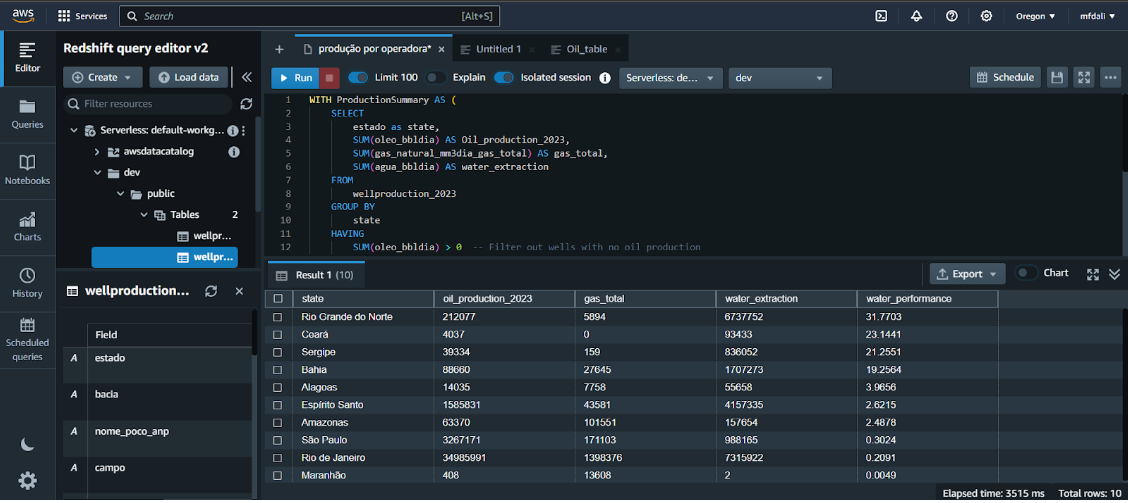

```
WITH ProductionSummary AS (
    SELECT
        estado as state,
        SUM(oleo_bbldia) AS Oil_production_2023,
        SUM(gas_natural_mm3dia_gas_total) AS gas_total,
        SUM(agua_bbldia) AS water_extraction
    FROM
        wellproduction_2023
    GROUP BY
        state
    HAVING
        SUM(oleo_bbldia) > 0  -- Filter out wells with no oil production
)
SELECT
    state,
    Oil_production_2023,
    gas_total,
    water_extraction,
    (water_extraction / Oil_production_2023) AS water_performance
FROM
    ProductionSummary
ORDER BY
    water_performance DESC
LIMIT 10
```

9. In which state are located the worst fields in efficience?

Benfica is the worst field which is located in Rio Grande do Norte

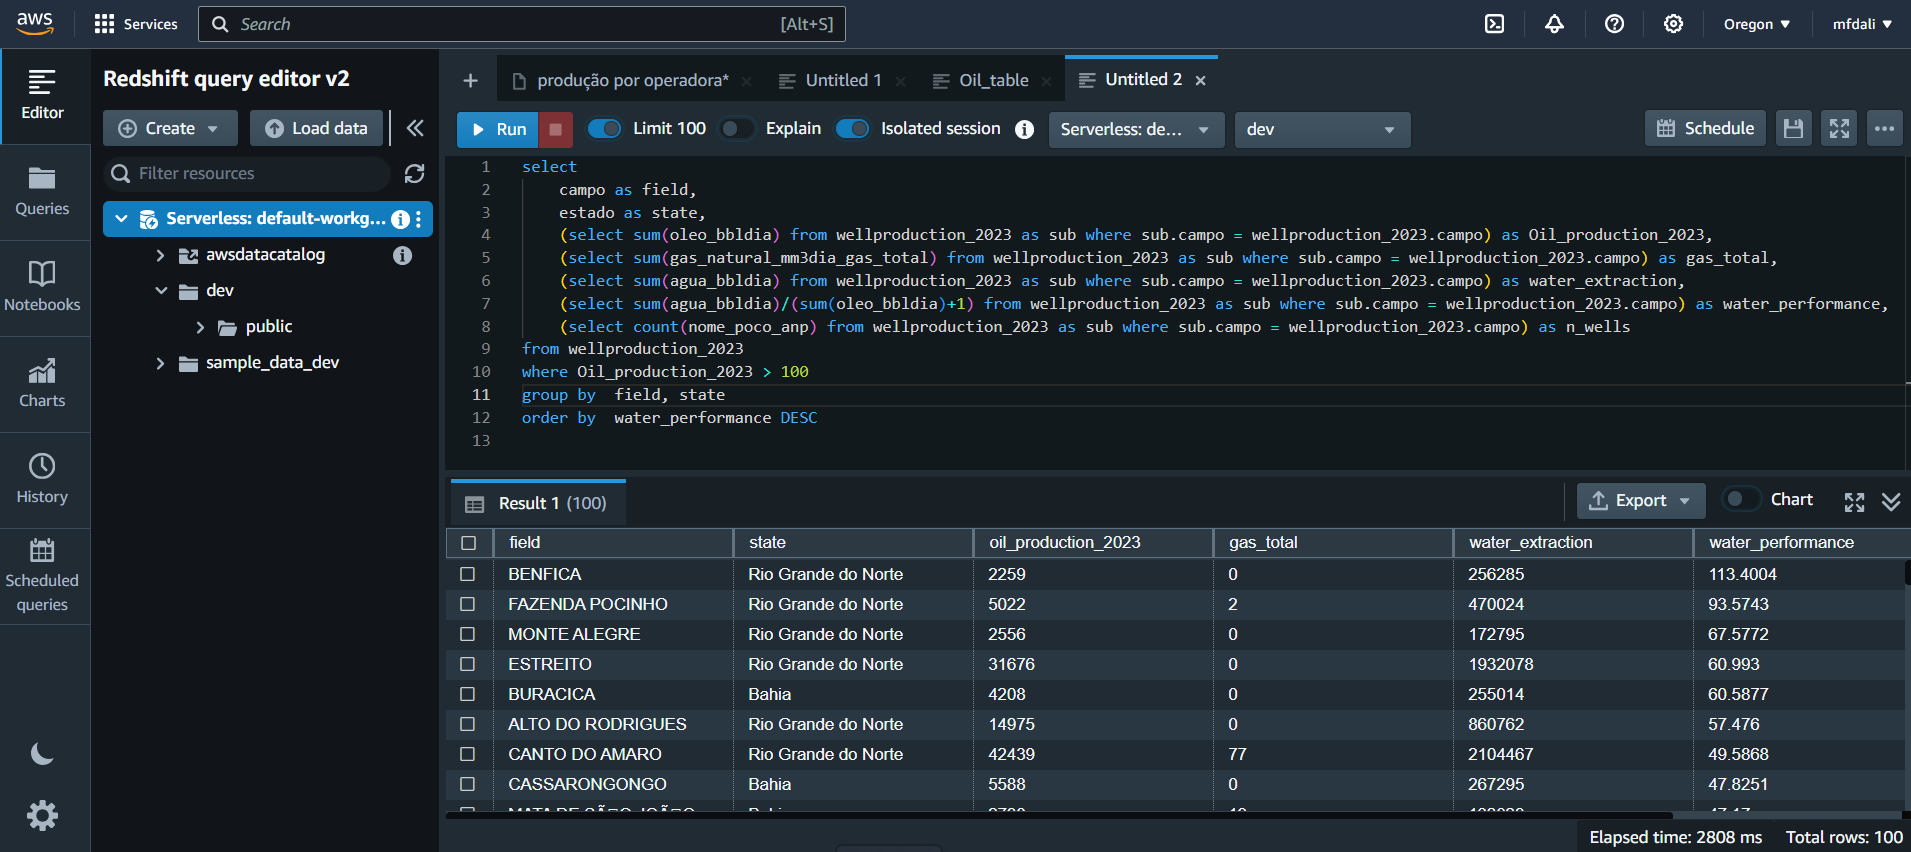

10. What are the 10 most inneficient wells with oil production?

PetroRecôncavo has the concesion of the worst well in terms of water performance. This well is located in Taquipe in Bahia state.

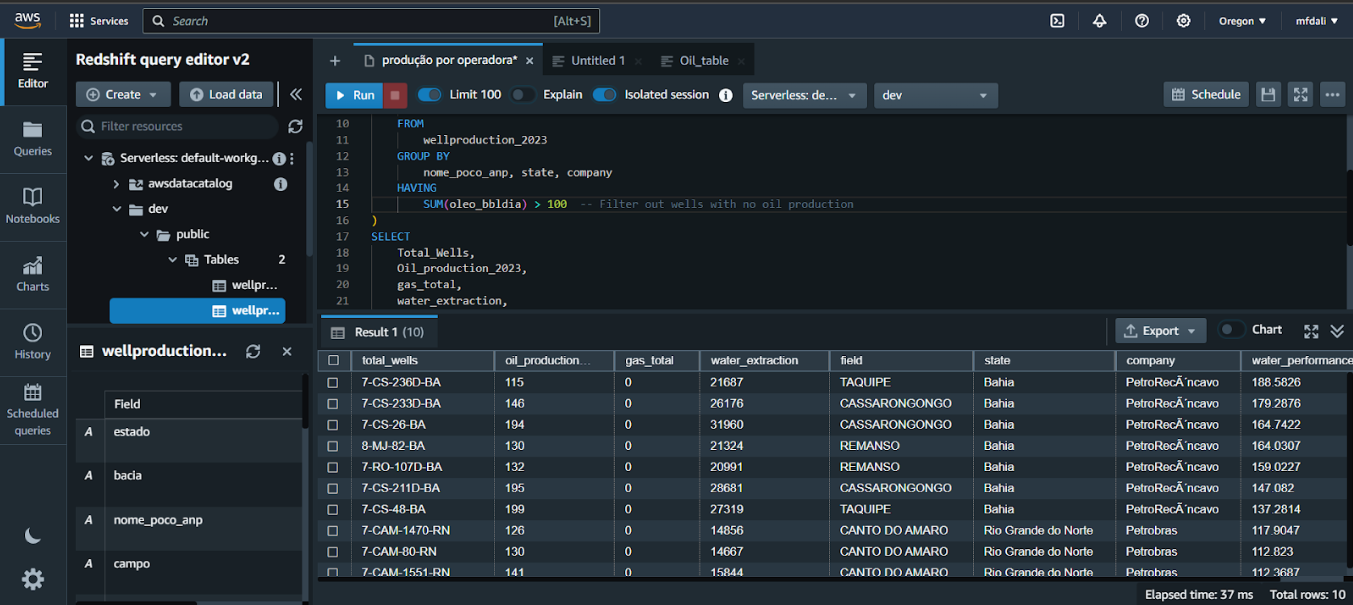

```
WITH ProductionSummary AS (
    SELECT
        nome_poco_anp AS Total_Wells,
        SUM(oleo_bbldia) AS Oil_production_2023,
        SUM(gas_natural_mm3dia_gas_total) AS gas_total,
        SUM(agua_bbldia) AS water_extraction,
        MAX(campo) AS field,
        estado as state,
        operador AS Company
    FROM
        wellproduction_2023
    GROUP BY
        nome_poco_anp, state, company
    HAVING
        SUM(oleo_bbldia) > 100  -- Filter out wells with no oil production
)
SELECT
    Total_Wells,
    Oil_production_2023,
    gas_total,
    water_extraction,
    field,
    state,
    Company,
    (water_extraction / Oil_production_2023) AS water_performance
FROM
    ProductionSummary
ORDER BY
    water_performance DESC
LIMIT 10
```